# Phân tích phim truyền thông và xã hội

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

## Giới thiệu chung

Trong những năm gần đây, các nhà phân tích và nhà đầu tư ngày càng quan tâm đến việc đánh giá rủi ro tài chính trong sản xuất phim. Nghiên cứu này sử dụng phân tích hồi quy tuyến tính bội để dự đoán thành công về mặt tài chính của phim và nghiên cứu mối quan hệ giữa số lần chiếu và năm.

Kết quả đạt được

## Bảng phân công công việc

## Phát biểu bài toán

Mục tiêu chính của đồ án là khám phá và phân tích tổng doanh thu của phim trong hai năm 2014 và 2015 cũng như kiểm tra mối quan hệ và ý nghĩa của một số biến giải thích. Hơn nữa, đồ án xây dựng một mô hình hồi quy tối ưu để đưa ra dự đoán về sự thành công về mặt tài chính, tức là tổng doanh thu của một bộ phim trong hai năm 2014 và 2015. 

## Giới thiệu về dữ liệu

Bộ dữ liệu phim truyền thông và xã hội (conventional and social media dataset) được sử dụng trong đồ án này có cấu trúc tương đối đơn giản mà một số người có ích kiến thức về phim truyền hình cũng có thể hiểu được. Vấn đề chính của bộ dữ liệu là missing values, và chúng tôi sẽ cố gắng xử lý nó bằng một số kỹ thuật đã biết.

Ngành công nghiệp điện ảnh là một ngành đóng góp đáng kể cho nền kinh tế của một quốc gia và là một nhà tuyển dụng lớn tại Hoa Kỳ. Do chi phí lớn liên quan đến sản xuất phim, các nhà phân tích cần nghiên cứu và hiểu các biến số chính góp phần vào thành công về mặt thương mại và tài chính của một bộ phim. Đồ án có thể cung cấp thông tin chi tiết về các tính năng chính góp phần vào thành công về mặt tài chính của các bộ phim và thúc đẩy nghiên cứu trong tương lai để xem xét mối quan hệ giữa các biến giải thích đặc biệt độc đáo trong tập dữ liệu. Hơn nữa nó còn có thể giúp các nhà sản xuất phim xác định những tính năng nào cần tập trung vào trong giai đoạn quảng bá để cải thiện thành công của bộ phim.

## Các câu hỏi phân tích (RQ - Research Question)

1. Mô hình hồi quy tuyến tính bội nào có thể dự đoán được tổng thu nhập trung bình của các bộ phim được phát hành vào năm 2014 và 2015?
2. Tổng thu nhập trung bình ước tính cho tất cả các bộ phim và tổng thu nhập trung bình dự đoán cho một bộ phim với các giá trị trung bình là bao nhiêu?
3. Mối quan hệ giữa tổng thu nhập và số lượng màn hình vào năm 2014 và 2015 là gì?

## Import thư viện

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(readxl)
library(mice)
library(VIM)
library(grid)
library(ggplot2)
library(cowplot)
library(missMDA)
library(FactoMineR)
library(TidyDensity)
library(MASS)
library(leaps)
library(lmtest)
library(Metrics)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



== Welcome to TidyDensity ===========================================================================
If you find this package useful, please leave a star: 
   https://github.com/spsanderson/TidyDensity'

If you enco

## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {      
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read_excel("../../data/part1/CSM.xlsx", sheet = 1)
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie              : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year               : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings            : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre              : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross              : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget             : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens            : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel             : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment          : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views              : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes              : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes           : num [1:231] 425 61 34 132 610 

In [4]:
names(raw_data)[names(raw_data) == 'Aggregate Followers'] <- 'AggregateFollowers'

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [5]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 231 dòng và 14 cột
dim(raw_data)

[1] 231  14

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [6]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Mỗi cột mang ý nghĩa gì?

In [7]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

Ý nghĩa từng cột:
- `Movie`: tên phim => Trong dữ liệu có kiểu dữ liệu chr => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Year`: năm phát hành => Trong dữ liệu có kiểu dữ liệu num => phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Ratings`: điểm đánh giá => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Genre`: thể loại phim => Trong dữ liệu có kiểu dữ liệu num => Chưa phù hợp => **Nên chuyển đổi biến này sang kiểu phân loại (Categorical)**
- `Gross`: tổng doanh thu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Budget`: tổng chi phí => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Screens`: số rạp chiếu => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Sequel`: phần phim => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Sentiment`: ý kiến khán giả => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số rời rạc (Numerical, Discretization)=> Phù hợp
- `Views`: số lượt xem => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Likes`: số lượt thích => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Dislikes`: số lượt chê => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Comments`: số bình luận => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp
- `Aggregate Followers`: số người theo dõi => Trong dữ liệu có kiểu dữ liệu num, phân loại biến kiểu số liên tục (Numerical, Continuous) => Phù hợp

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

In [8]:
# 1. Genre 
is.factor(raw_data$Genre) #False 

[1] FALSE

In [9]:
# 2.Movie 
is.factor(raw_data$Movie) #False

[1] FALSE

In [10]:
# Modifications
processed_data <- raw_data
processed_data$Genre <- as.factor(processed_data$Genre)

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [11]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate median
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

# Function to calculate lower quartile
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

# Function to calculate upper quartile
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [12]:
# Select numerical columns
num_col_info_df <- as.data.frame(processed_data) %>% select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- as.data.frame(processed_data) %>%
  select_if(is.numeric) %>%
  summarise(
    across(everything(), list(
      missing_ratio = ~ missing_ratio(.),
      min = ~ min(., na.rm = TRUE),
      lower_quartile = ~ lower_quartile(.),
      median = ~ median_custom(.),
      upper_quartile = ~ upper_quartile(.),
      max = ~ max(., na.rm = TRUE)
    ))
  )

num_col_info_df <- num_col_info_df %>%
  pivot_longer(
    cols = everything(),
    names_to = c("variable", ".value"),
    names_sep = "_"
  )

print(num_col_info_df)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 36 rows [1, 3, 5, 7, 9, 11,
13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, ...].”


# A tibble: 12 × 7
   variable           missing     min      lower     median      upper       max
   <chr>                <dbl>   <dbl>      <dbl>      <dbl>      <dbl>     <dbl>
 1 Year                   0    2014       2014       2014       2015      2.02e3
 2 Ratings                0       3.1        5.8        6.5        7.1    8.7 e0
 3 Gross                  0    2470   10300000   37400000   89350000      6.43e8
 4 Budget                 0.4 70000    9000000   28000000   65000000      2.5 e8
 5 Screens                4.3     2        449       2777       3372      4.32e3
 6 Sequel                 0       1          1          1          1      7   e0
 7 Sentiment              0     -38          0          0          5.5    2.9 e1
 8 Views                  0     698     623302    2409338    5217380.     3.26e7
 9 Likes                  0       1       1776.      6096      15248.     3.71e5
10 Dislikes               0       0        106.       341        698.     1.40e4
11 Commen

**Nhận xét**
- Dữ liệu có hiện tượng missing values.
- Cụ thể, ta thấy biến `Aggregate Followers` có tỷ lệ missing 15.2%, biến `Screens` có tỷ lệ 4.3% và biến `Budget` có tỷ lệ missing 0.4%.
- Có những bộ phim không có likes/ dislikes/ comments, ta sẽ loại bỏ những dòng này.

In [13]:
processed_data <- processed_data %>% filter(Likes != 0)
processed_data <- processed_data %>% filter(Dislikes != 0)
processed_data <- processed_data %>% filter(Comments != 0)

Kiểm tra lại với hàm `summary`

In [14]:
print(summary(as.data.frame(processed_data) %>% select_if(is.numeric)))

      Year         Ratings          Gross               Budget         
 Min.   :2014   Min.   :3.100   Min.   :     2470   Min.   :    70000  
 1st Qu.:2014   1st Qu.:5.800   1st Qu.: 10525000   1st Qu.:  9000000  
 Median :2014   Median :6.500   Median : 37650000   Median : 28000000  
 Mean   :2014   Mean   :6.435   Mean   : 68185216   Mean   : 47688067  
 3rd Qu.:2015   3rd Qu.:7.100   3rd Qu.: 89375000   3rd Qu.: 65000000  
 Max.   :2015   Max.   :8.700   Max.   :643000000   Max.   :250000000  
                                                    NA's   :1          
    Screens         Sequel        Sentiment           Views         
 Min.   :   2   Min.   :1.000   Min.   :-38.000   Min.   :     698  
 1st Qu.: 461   1st Qu.:1.000   1st Qu.:  0.000   1st Qu.:  702823  
 Median :2777   Median :1.000   Median :  0.000   Median : 2529698  
 Mean   :2217   Mean   :1.341   Mean   :  2.845   Mean   : 3794866  
 3rd Qu.:3372   3rd Qu.:1.000   3rd Qu.:  6.000   3rd Qu.: 5222041  
 Max.   :4

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

Ta xem xét số lượng phần tử duy nhất (unique) của biến Movie

In [15]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

# Function to calculate number of unique values
num_values <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

# Function to calculate value ratios
value_ratios <- function(s) {
  s <- as.character(s)  # Convert factors to character
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

# Select categorical columns (assuming character and factor columns as categorical)
cat_col_info_df <- processed_data %>%
  select_if(~ is.character(.) || is.factor(.))

# Function to aggregate results for each column
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Apply the aggregation function
cat_col_info_df <- aggregate_results(cat_col_info_df)

# Print the result
print(cat_col_info_df)

      column missing_ratio num_values value_ratios
Movie  Movie             0        226 0.4, 0.4....
Genre  Genre             0         11 28.3, 4.....


Ta thấy số lượng phần tử đơn trong Movie bằng số lượng record trong dữ liệu. Ta có thể loại bỏ biến này trong quá trình phân tích phía sau.

In [16]:
length(unique(processed_data$Movie))

[1] 226

Ta thấy biến `Genre` có 11 giá trị đơn, bao gồm 8, 1, 3, 10, 15, 12, 9, 2, 7, 6, 4.

In [17]:
unique(processed_data$Genre)
length(unique(processed_data$Genre))

[1] 8  1  3  10 15 12 9  2  7  6  4 
Levels: 1 2 3 4 6 7 8 9 10 12 15

[1] 11

In [18]:
# df <- data.frame(
#     year = unique(raw_data$Year),
#     percentage = c(70.6, 29.4)
# )

# # colnames(plot_df) <- c("Value", "Percentage")
# # plot_df

# bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
# geom_bar(width = 1, stat = "identity")
# pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
# pie

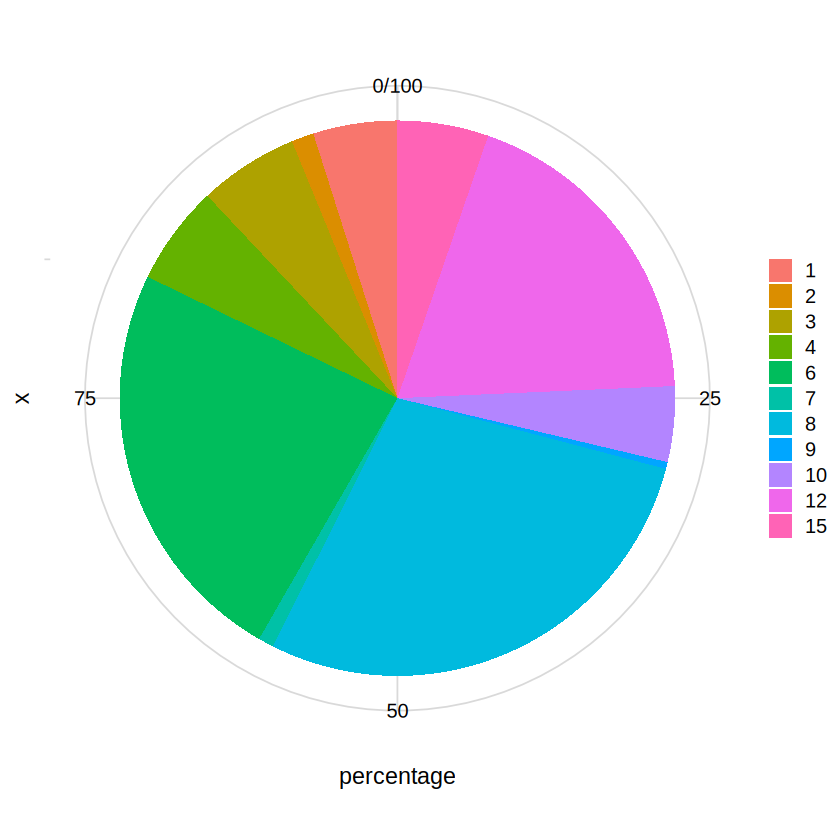

In [19]:
df <- data.frame(
    year = unique(processed_data$Genre),
    percentage = c(t(as.data.frame(cat_col_info_df$value_ratios[[2]])[1, ]))
)

bp<- ggplot(df, aes(x="", y=percentage, fill=year))+
geom_bar(width = 1, stat = "identity")
pie <- bp + coord_polar("y", start=0) + theme_minimal_grid() + theme(legend.title = element_blank())
pie

### Xử lý dữ liệu bị thiếu

Ta nhìn lại tỷ lệ missing values

In [20]:
print(apply(processed_data, 2, function(x) {sum(is.na(x))/length(x)*100}))

             Movie               Year            Ratings              Genre 
         0.0000000          0.0000000          0.0000000          0.0000000 
             Gross             Budget            Screens             Sequel 
         0.0000000          0.4424779          3.9823009          0.0000000 
         Sentiment              Views              Likes           Dislikes 
         0.0000000          0.0000000          0.0000000          0.0000000 
          Comments AggregateFollowers 
         0.0000000         15.4867257 


,Movie,Year,Ratings,Genre,Gross,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Budget,Screens,AggregateFollowers,
183,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
33,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
7,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,2
1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
,0,0,0,0,0,0,0,0,0,0,0,1,9,35,45


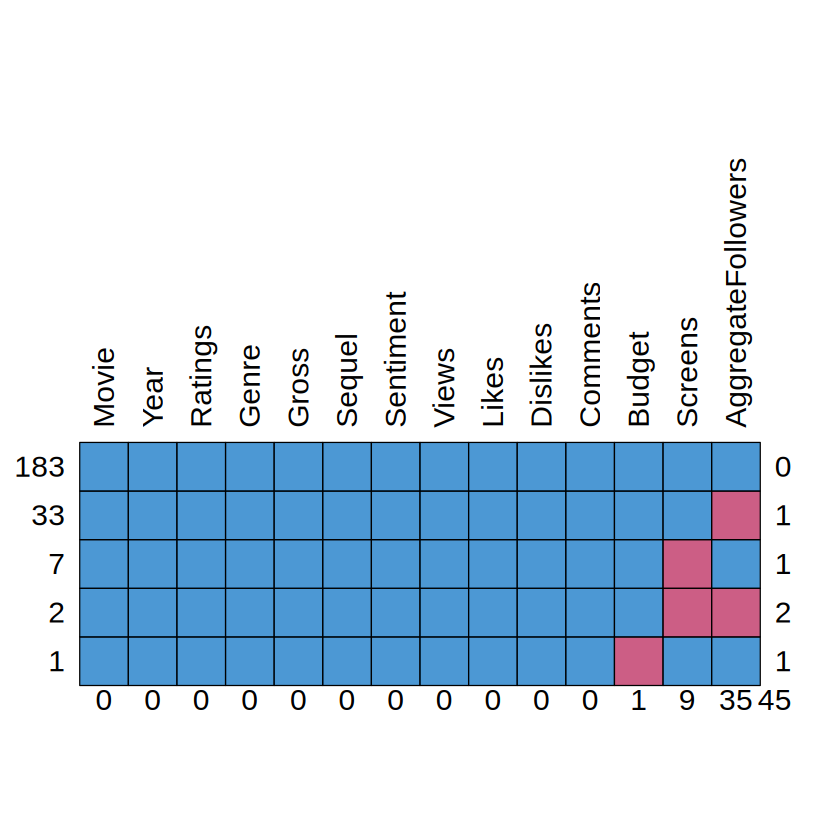

In [21]:
par(mar = c(5, 5, 2, 2), cex = 1.5)
md_plot <- md.pattern(processed_data, plot = TRUE, rotate.names = TRUE)
md_plot

Giá trị 0 ám chỉ giá trị bị thiếu. Lấy ví dụ, biến `Budget` có chứa 1 dòng bị missing value, `Screens` có 10 dòng bị missing values, `Aggregate Followers` có 35 dòng bị missing values.

In [22]:
md.pairs(processed_data)

,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,AggregateFollowers
Movie,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Year,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Ratings,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Genre,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Gross,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Budget,225,225,225,225,225,225,216,225,225,225,225,225,225,190
Screens,217,217,217,217,217,216,217,217,217,217,217,217,217,184
Sequel,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Sentiment,226,226,226,226,226,225,217,226,226,226,226,226,226,191
Views,226,226,226,226,226,225,217,226,226,226,226,226,226,191


Bằng cách dùng lên trên, ta có được bốn bảng bao gồm `rr`, `rm`, `mr`, và `mm`
- Bảng `rr` (response-response) cho ta biết có bao nhiêu điểm dữ liệu được quan sát.
- Bảng `rm` (response-missing) cho ta biết các dòng quan sát được, cột bị thiếu.
- Bảng `mr` (missing -response) cho ta biết các dòng bị thiếu, cột quan sát được.
- Bảng `mm` (missing -missing) cho ta biết các hai, dòng và cột bị thiếu. 

Ta thử trực quan hóa bằng hàm `marginplot`. Một cách đơn giản thì hàm này trực quan phân phối của dữ liệu bị thiếu của một biến trong một biến khác (màu đỏ), và phân phối dữ liệu không bị thiếu (màu xanh). Ở đây, ta thử nghiệm ba trường hợp
- `Budget` và `Screens`
- `Budget` và `Aggregate Followers`
- `Screens` và `Aggregate Followers`

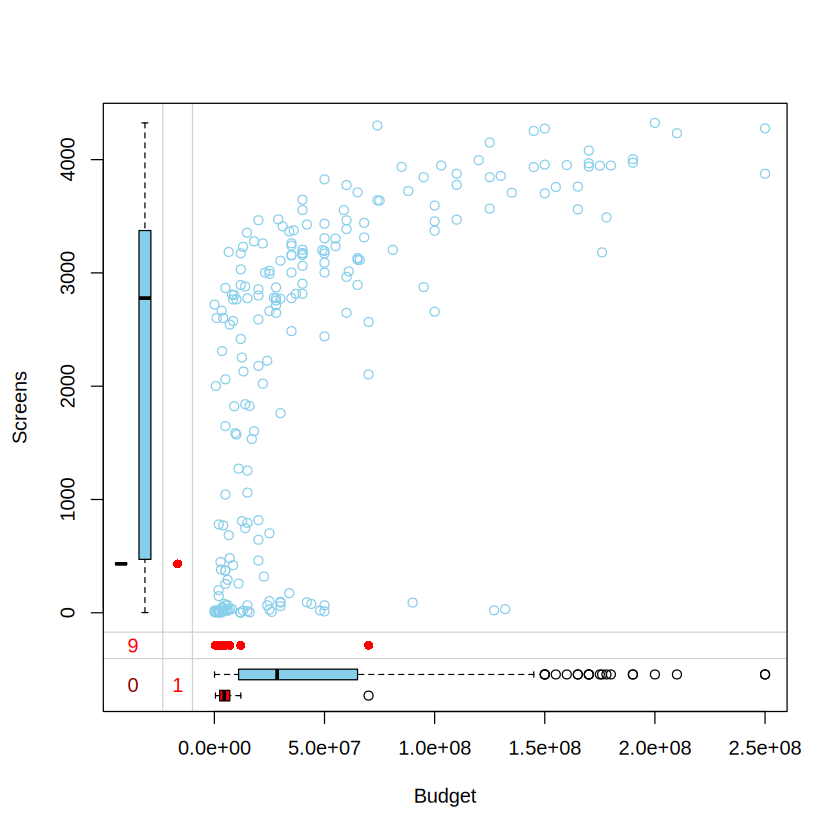

In [23]:
marginplot(processed_data[, c('Budget', 'Screens')])

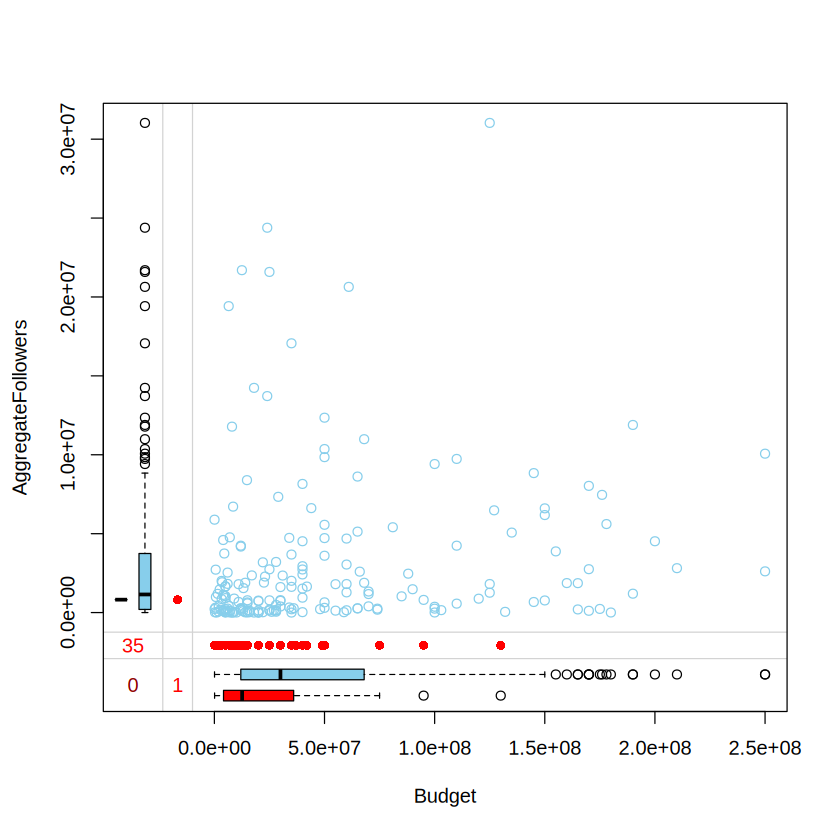

In [24]:
marginplot(processed_data[, c('Budget', 'AggregateFollowers')])

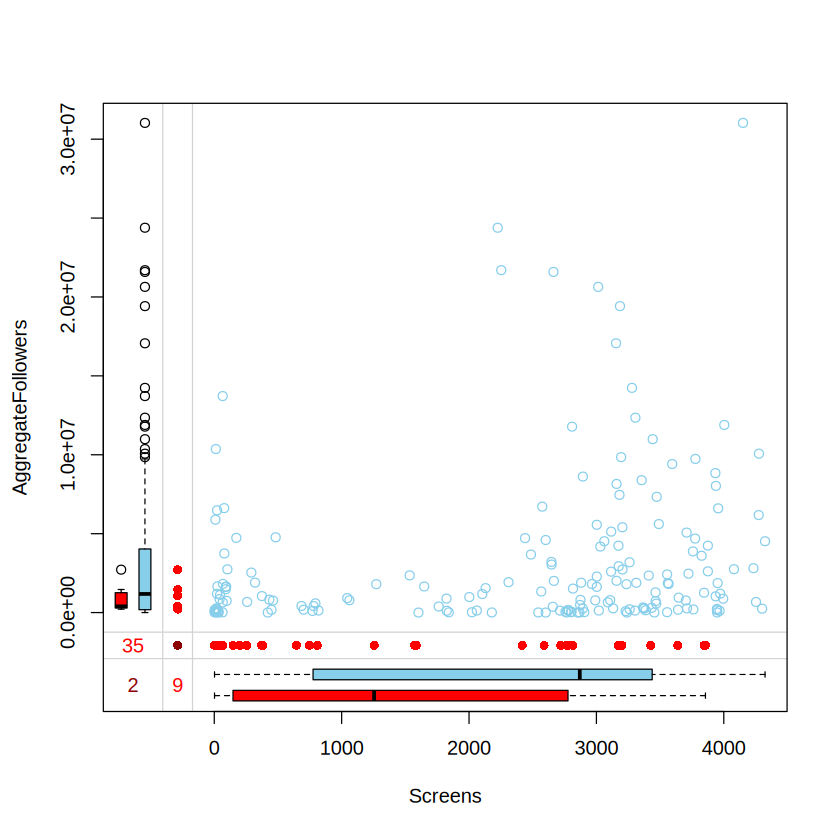

In [25]:
marginplot(processed_data[, c('Screens', 'AggregateFollowers')])

In [26]:
imputed_Budget <- data.frame(
  original = processed_data$Budget,
  imputed_zero = replace(processed_data$Budget, is.na(processed_data$Budget), 0),
  imputed_mean = replace(processed_data$Budget, is.na(processed_data$Budget), mean(processed_data$Budget, na.rm = TRUE)),
  imputed_median = replace(processed_data$Budget, is.na(processed_data$Budget), median(processed_data$Budget, na.rm = TRUE))
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


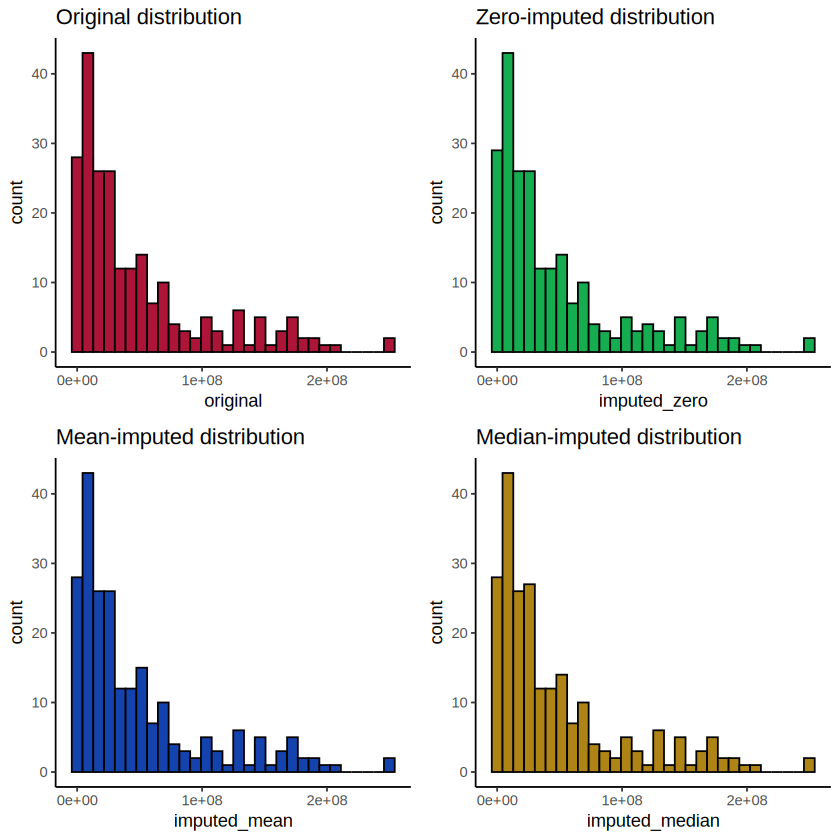

In [27]:
h1 <- ggplot(imputed_Budget, aes(x = original)) +
  geom_histogram(fill = "#ad1538", color = "#000000", position = "identity") +
  ggtitle("Original distribution") +
  theme_classic()
h2 <- ggplot(imputed_Budget, aes(x = imputed_zero)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Zero-imputed distribution") +
  theme_classic()
h3 <- ggplot(imputed_Budget, aes(x = imputed_mean)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Mean-imputed distribution") +
  theme_classic()
h4 <- ggplot(imputed_Budget, aes(x = imputed_median)) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("Median-imputed distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, nrow = 2, ncol = 2, rel_widths = c(1, 1), rel_heights = c(1, 1))

Do biến `Budget` chỉ có một dòng bị thiếu nên khi sử dụng imputation bằng các trường hợp  mean, zero và median thì phân phối của biến này không có gì thay đổi. Ta sử dụng impute bằng mean để xử lý.

In [28]:
processed_data <- processed_data %>%
  mutate(Budget = ifelse(is.na(Budget), mean(Budget, na.rm = TRUE), Budget))

In [29]:
imputed_Screens <- data.frame(
  original = processed_data$Screens,
  imputed_zero = replace(processed_data$Screens, is.na(processed_data$Screens), 0),
  imputed_mean = replace(processed_data$Screens, is.na(processed_data$Screens), mean(processed_data$Screens, na.rm = TRUE)),
  imputed_median = replace(processed_data$Screens, is.na(processed_data$Screens), median(processed_data$Screens, na.rm = TRUE))
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


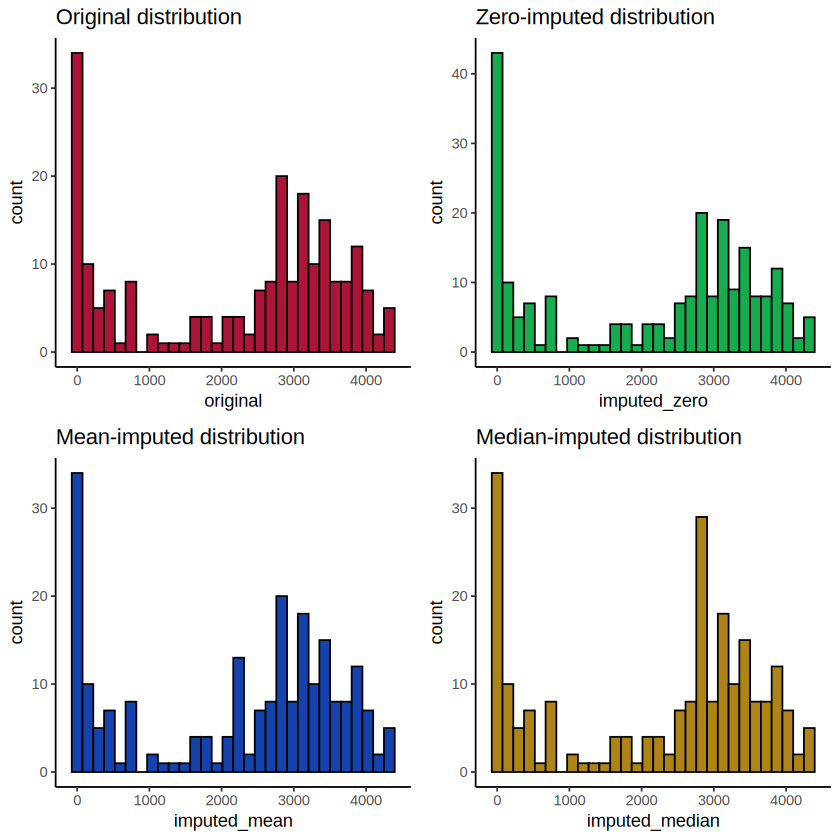

In [30]:
h1 <- ggplot(imputed_Screens, aes(x = original)) +
  geom_histogram(fill = "#ad1538", color = "#000000", position = "identity") +
  ggtitle("Original distribution") +
  theme_classic()
h2 <- ggplot(imputed_Screens, aes(x = imputed_zero)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Zero-imputed distribution") +
  theme_classic()
h3 <- ggplot(imputed_Screens, aes(x = imputed_mean)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Mean-imputed distribution") +
  theme_classic()
h4 <- ggplot(imputed_Screens, aes(x = imputed_median)) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("Median-imputed distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, nrow = 2, ncol = 2, rel_widths = c(1, 1), rel_heights = c(1, 1))

Ta thấy khi sử dụng mean-imputed, phân phối của biến đã được biến đổi tương đối gần giống với biến ban đầu. Do đó, ta sẽ dụng mean-imputed.

In [31]:
processed_data <- processed_data %>%
  mutate(Screens = ifelse(is.na(Screens), mean(Screens, na.rm = TRUE), Screens))

In [32]:
imputed_Aggregate_Followers <- data.frame(
  original = processed_data$AggregateFollowers,
  imputed_zero = replace(processed_data$AggregateFollowers, is.na(processed_data$AggregateFollowers), 0),
  imputed_mean = replace(processed_data$AggregateFollowers, is.na(processed_data$AggregateFollowers), mean(processed_data$AggregateFollowers, na.rm = TRUE)),
  imputed_median = replace(processed_data$AggregateFollowers, is.na(processed_data$AggregateFollowers), median(processed_data$AggregateFollowers, na.rm = TRUE))
)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


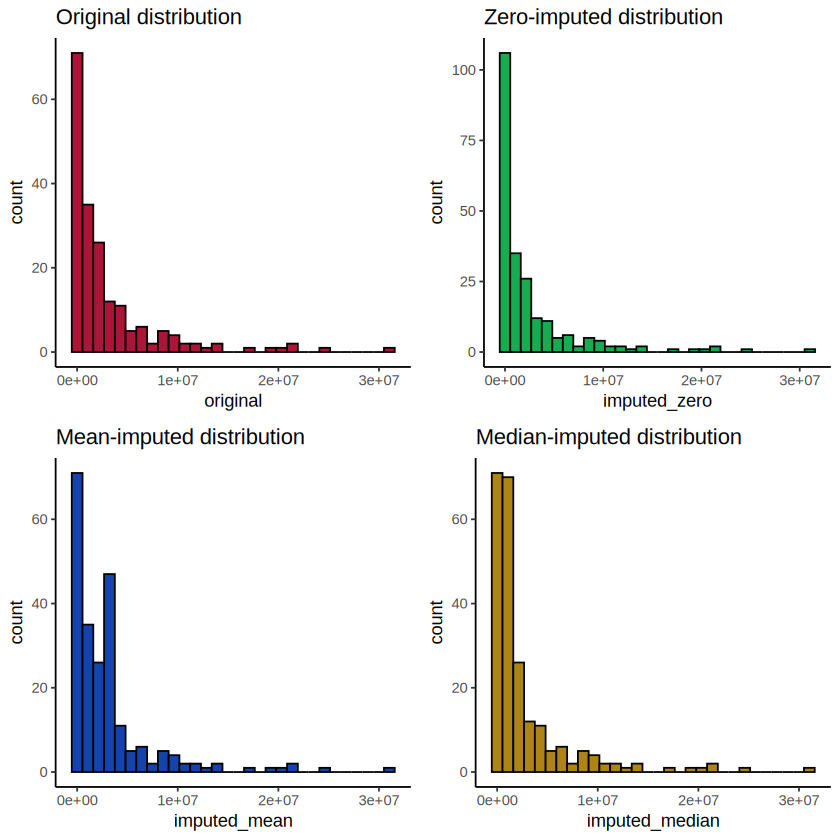

In [33]:
h1 <- ggplot(imputed_Aggregate_Followers, aes(x = original)) +
  geom_histogram(fill = "#ad1538", color = "#000000", position = "identity") +
  ggtitle("Original distribution") +
  theme_classic()
h2 <- ggplot(imputed_Aggregate_Followers, aes(x = imputed_zero)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Zero-imputed distribution") +
  theme_classic()
h3 <- ggplot(imputed_Aggregate_Followers, aes(x = imputed_mean)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Mean-imputed distribution") +
  theme_classic()
h4 <- ggplot(imputed_Aggregate_Followers, aes(x = imputed_median)) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("Median-imputed distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, nrow = 2, ncol = 2, rel_widths = c(1, 1), rel_heights = c(1, 1))

Ta thấy khi sử dụng median-imputed, phân phối của biến sau khi được biến đổi tốt và gần giống với ban đầu hơn. Do đó, ta có thể chọn median-imputed.

In [34]:
processed_data <- processed_data %>%
  mutate(AggregateFollowers = ifelse(is.na(AggregateFollowers), median(AggregateFollowers, na.rm = TRUE), AggregateFollowers))

Kiểm tra lại một lần nữa trước khi xử lý tiếp

In [35]:
print(apply(processed_data, 2, function(x) {sum(is.na(x))/length(x)*100}))

             Movie               Year            Ratings              Genre 
                 0                  0                  0                  0 
             Gross             Budget            Screens             Sequel 
                 0                  0                  0                  0 
         Sentiment              Views              Likes           Dislikes 
                 0                  0                  0                  0 
          Comments AggregateFollowers 
                 0                  0 


### Thử xử lý dữ liệu bị thiếu bằng PCA

In [36]:
str(raw_data)

tibble [231 × 14] (S3: tbl_df/tbl/data.frame)
 $ Movie             : chr [1:231] "13 Sins" "22 Jump Street" "3 Days to Kill" "300: Rise of an Empire" ...
 $ Year              : num [1:231] 2014 2014 2014 2014 2014 ...
 $ Ratings           : num [1:231] 6.3 7.1 6.2 6.3 4.7 4.6 6.1 7.1 6.5 6.1 ...
 $ Genre             : num [1:231] 8 1 1 1 8 3 8 1 10 8 ...
 $ Gross             : num [1:231] 9.13e+03 1.92e+08 3.07e+07 1.06e+08 1.73e+07 2.90e+04 4.26e+07 5.75e+06 2.60e+07 4.86e+07 ...
 $ Budget            : num [1:231] 4.00e+06 5.00e+07 2.80e+07 1.10e+08 3.50e+06 5.00e+05 4.00e+07 2.00e+07 2.80e+07 1.25e+07 ...
 $ Screens           : num [1:231] 45 3306 2872 3470 2310 ...
 $ Sequel            : num [1:231] 1 2 1 2 2 1 1 1 1 1 ...
 $ Sentiment         : num [1:231] 0 2 0 0 0 0 0 2 3 0 ...
 $ Views             : num [1:231] 3280543 583289 304861 452917 3145573 ...
 $ Likes             : num [1:231] 4632 3465 328 2429 12163 ...
 $ Dislikes          : num [1:231] 425 61 34 132 610 7 419 197 41

In [37]:
nPCs <- estim_ncpPCA(raw_data[, -c(1)])
print(nPCs)

$ncp
[1] 2

$criterion
           0            1            2            3            4            5 
8.461633e+14 6.896501e+14 3.453184e+14 4.072345e+14 4.950558e+14 5.955508e+14 



In [38]:
processed_data2 <- imputePCA(raw_data[, -c(1)], ncp = nPCs$ncp, scale = TRUE)
processed_data2 <- processed_data2$completeObs

In [39]:
print(apply(processed_data2, 2, function(x) {sum(is.na(x))/length(x)*100}))

              Year            Ratings              Genre              Gross 
                 0                  0                  0                  0 
            Budget            Screens             Sequel          Sentiment 
                 0                  0                  0                  0 
             Views              Likes           Dislikes           Comments 
                 0                  0                  0                  0 
AggregateFollowers 
                 0 


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 35 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


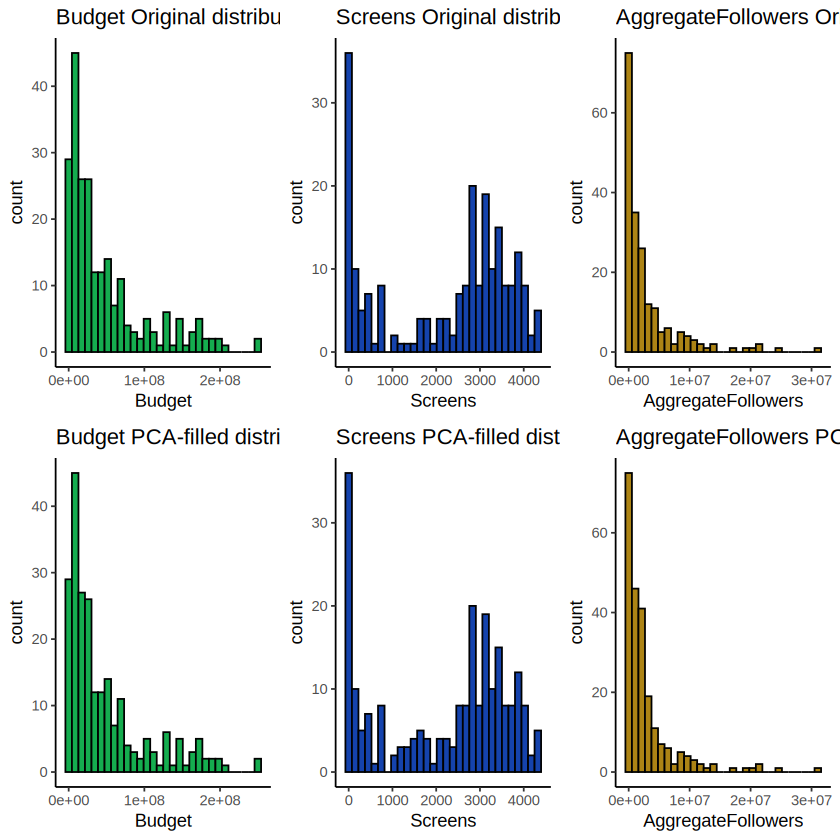

In [40]:
h1 <- ggplot(raw_data, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget Original distribution") +
  theme_classic()
h2 <- ggplot(raw_data, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens Original distribution") +
  theme_classic()
h3 <- ggplot(raw_data, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers Original distribution") +
  theme_classic()

  
h4 <- ggplot(processed_data2, aes(x = Budget)) +
  geom_histogram(fill = "#15ad4f", color = "#000000", position = "identity") +
  ggtitle("Budget PCA-filled distribution") +
  theme_classic()
h5 <- ggplot(processed_data2, aes(x = Screens)) +
  geom_histogram(fill = "#1543ad", color = "#000000", position = "identity") +
  ggtitle("Screens PCA-filled distribution") +
  theme_classic()
h6 <- ggplot(processed_data2, aes(x = AggregateFollowers )) +
  geom_histogram(fill = "#ad8415", color = "#000000", position = "identity") +
  ggtitle("AggregateFollowers PCA-filled distribution") +
  theme_classic()

plot_grid(h1, h2, h3, h4, h5, h6, nrow = 2, ncol = 3, rel_widths = c(1, 1), rel_heights = c(1, 1))

Đến đây, ta thấy PCA fill missing value rất tốt. Ta sẽ sử dụng nó.

### Loại bỏ hoàn toàn dữ liệu bị thiếu

In [41]:
removed_df = na.omit(raw_data)
dim(raw_data) # Trước khi loại bỏ hoàn toàn dữ liệu bị thiếu
dim(removed_df) # Sau khi loại bỏ

# Loại bỏ 44/ 231, tức chiếm tỷ lệ 19.05%

[1] 231  14

[1] 187  14

## Xử lý đa cộng tuyến

In [42]:
processed_data_final <- as.data.frame(removed_df)
processed_data_final <- processed_data_final %>% filter(Likes != 0)
processed_data_final <- processed_data_final %>% filter(Dislikes != 0)
processed_data_final <- processed_data_final %>% filter(Comments != 0)

processed_data_final <- processed_data_final[,-c(1)] # Loại bỏ cột tên phim

In [43]:
model <- lm(Gross ~ ., data = processed_data_final)

vif_values <- vif(model)
print(vif_values)

# Interpret the results
if(any(vif_values > 5)) {
  cat("Warning: High multicollinearity detected.\n")
} else {
  cat("No high multicollinearity detected.\n")
}

              Year            Ratings              Genre             Budget 
          1.257188           1.347879           1.155113           2.138199 
           Screens             Sequel          Sentiment              Views 
          1.739074           1.412994           1.110006           4.903107 
             Likes           Dislikes           Comments AggregateFollowers 
          7.171854           3.271273           8.083039           1.159232 


In [44]:
cleaned_df <- remove_high_vif ("Gross", processed_data_final, threshold = 6)

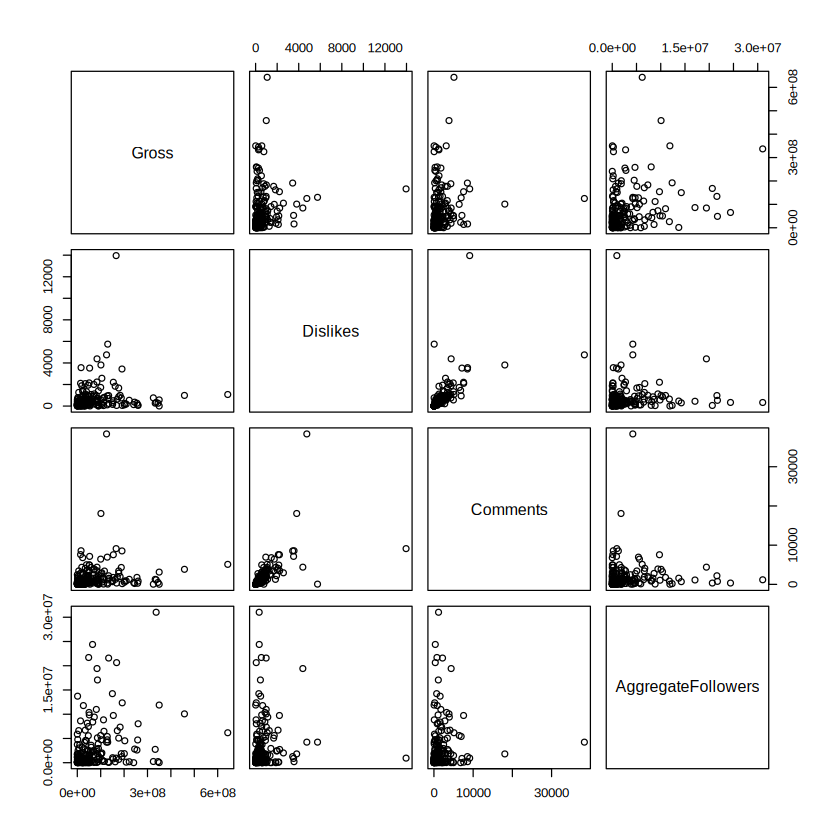

In [45]:
plot(cleaned_df)

## Khảo sát ngoại lai

In [46]:
Q1 <- quantile(cleaned_df$'Gross', 0.25)
Q3 <- quantile(cleaned_df$'Gross', 0.75)
IQR <- Q3 - Q1
lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR
outliers <- which(cleaned_df$'Gross' < lower_bound | cleaned_df$'Gross' > upper_bound)
outliers

cleaned_df <- cleaned_df[-outliers, ]
# dim(cleaned_df)
# dim(df_cleaned)

[1]  10  24  41  57 100 103 107 120 130 131 132 133 134

## Quay lại bước phân tích xen kẽ với tiền xử lý dữ liệu

In [47]:
names(cleaned_df)

[1] "Gross"              "Dislikes"           "Comments"          
[4] "AggregateFollowers"

### Phân tích biến `Gross`

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


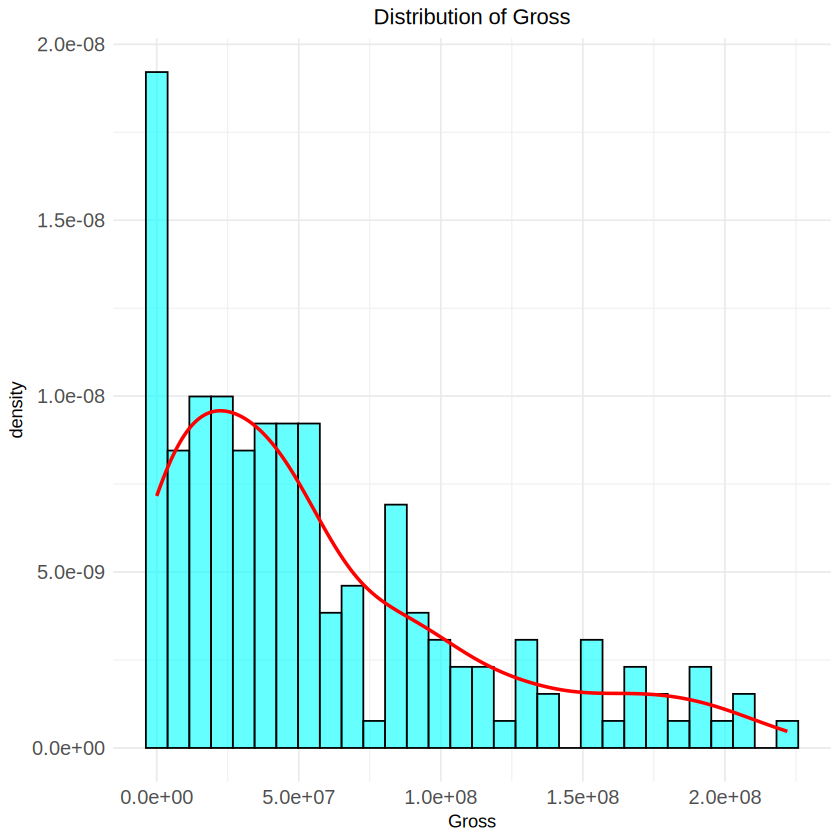

In [48]:
# tidy_empirical(train$Gross) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

**Nhận xét**:
- Nhìn vào biểu đồ, ta thấy phân phối của biến `Gross` bị lệch phải.

Ta thử sử dụng log-transform nó.

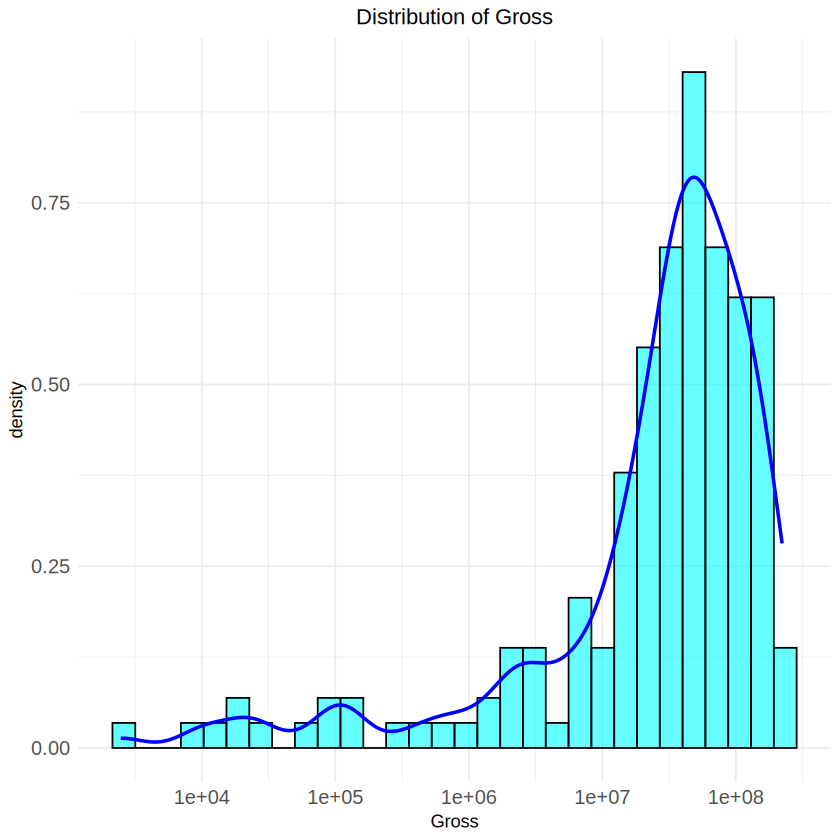

In [49]:
ggplot(cleaned_df, aes(x = Gross)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "blue", size = 1) +
  scale_x_log10() +  # Apply log scale to the x-axis
  theme_minimal() +
  ggtitle("Distribution of Gross") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

Ta nhận thấy sau khi sử dụng log-transform, dữ liệu bị lệch trái. Do đó, ta thử sử dụng box-cox.

[1] "Optimal lambda:  0.343434343434343"


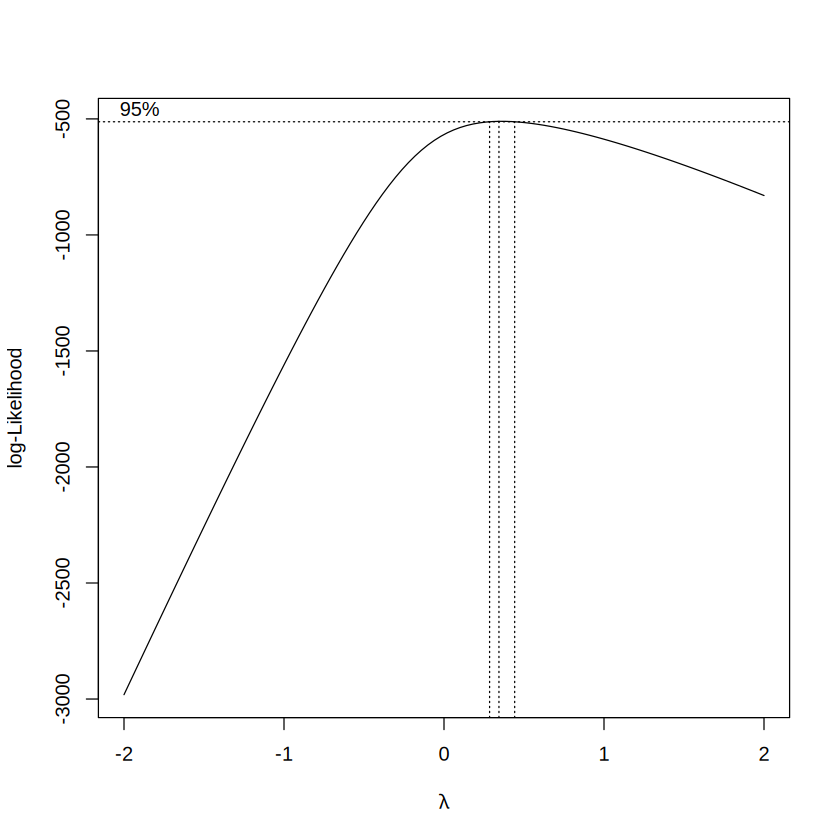

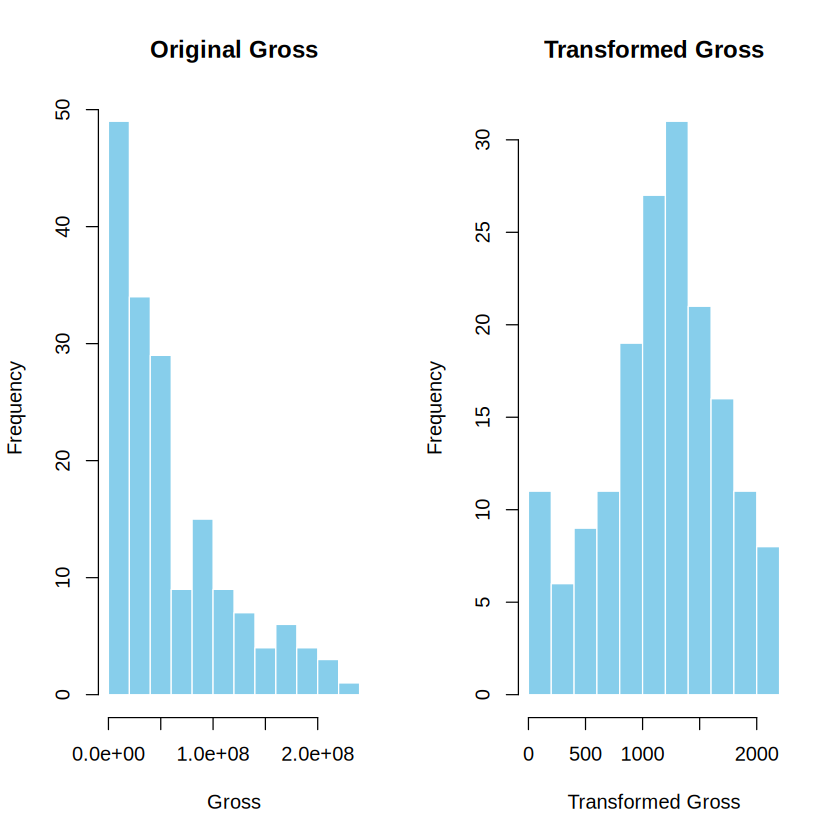

In [50]:
response_variable <- cleaned_df$Gross 

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Gross", xlab = "Gross", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Gross", xlab = "Transformed Gross", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

Ta có được giá trị lambda tối ưu là 0.33 và sử dụng giá trị này để biến đổi biến `Gross`. Biểu đồ histogram phía bên dưới thể hiện phân phối của biến này trước và sau khi biến đổi. Dễ dàng thấy được, sau khi biến đổi, biến này đã tương đối chuẩn hơn.

Ta thực hiện gán giá trị đã được biến đổi vào dataframe.

In [51]:
cleaned_df$Gross <- transformed_response

### Phân tích biến `Dislikes`

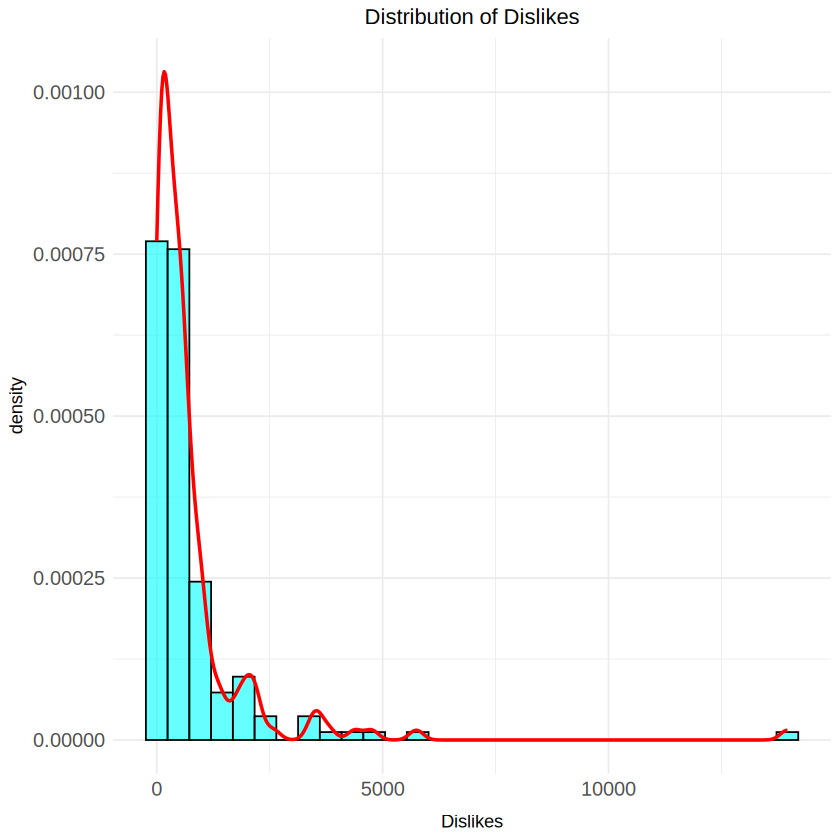

In [52]:
# tidy_empirical(train$Dislikes) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Dislikes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Dislikes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

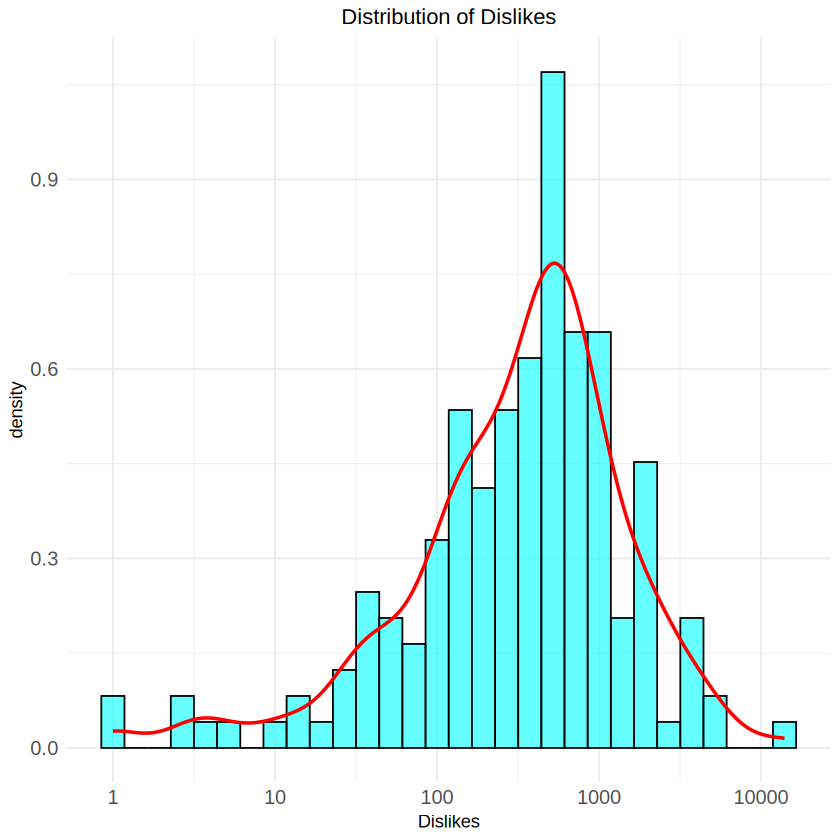

In [53]:
ggplot(cleaned_df, aes(x = Dislikes)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of Dislikes") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


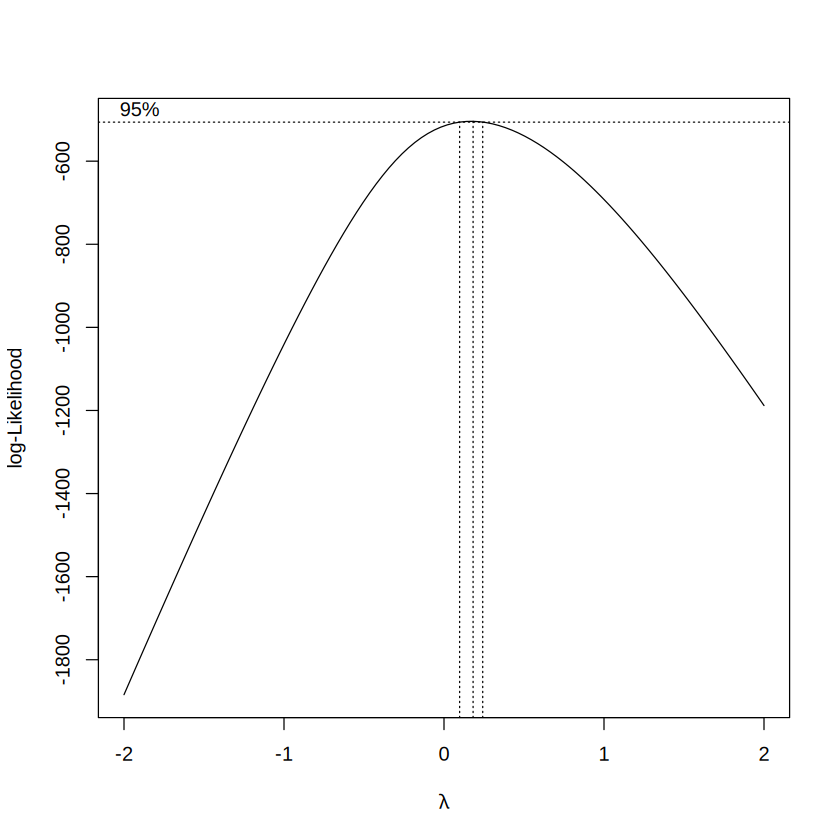

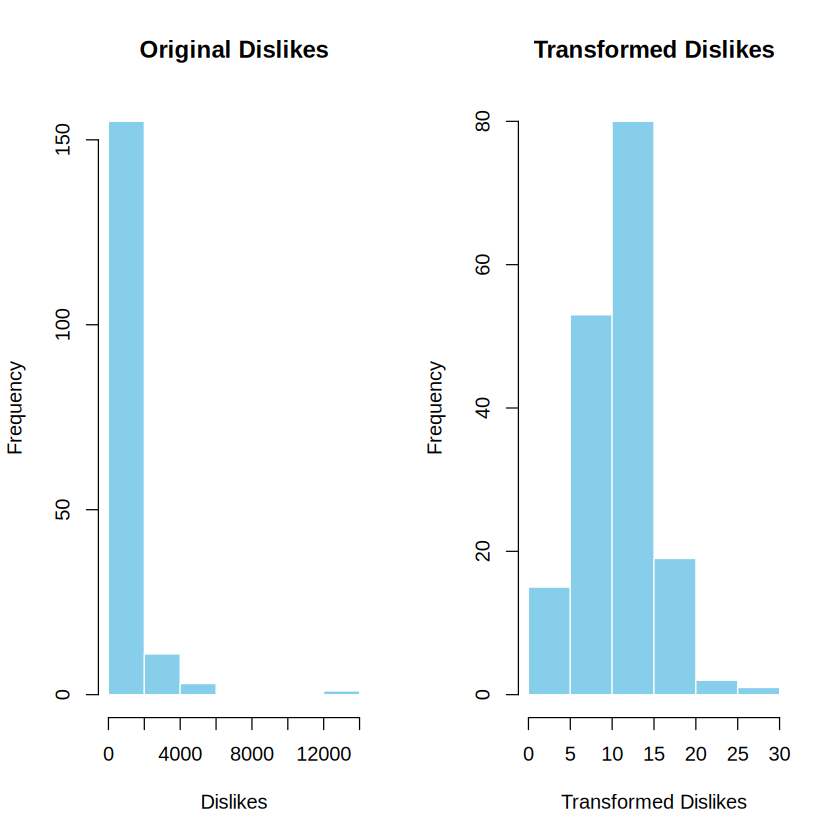

In [54]:
response_variable <- cleaned_df$Dislikes[cleaned_df$Dislikes != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Dislikes", xlab = "Dislikes", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Dislikes", xlab = "Transformed Dislikes", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `Dislikes` đã tương đối chuẩn hơn.

In [55]:
cleaned_df$Dislikes <- (cleaned_df$Dislikes^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `Comments`

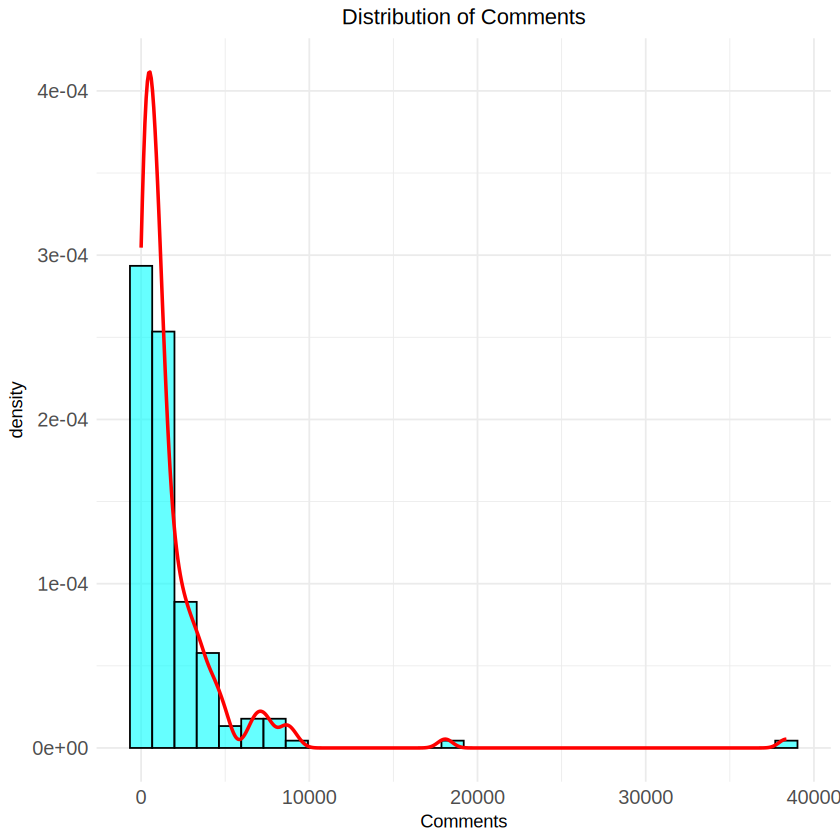

In [56]:
# tidy_empirical(train$Comments) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = Comments)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of Comments") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )


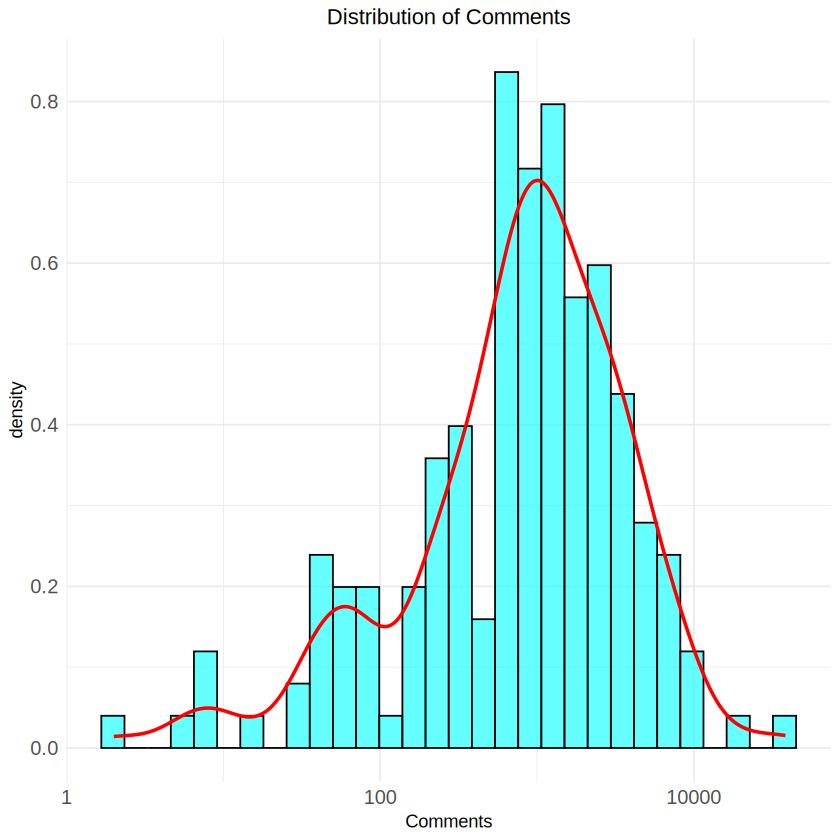

In [57]:
ggplot(cleaned_df, aes(x = Comments)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of Comments") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.181818181818182"


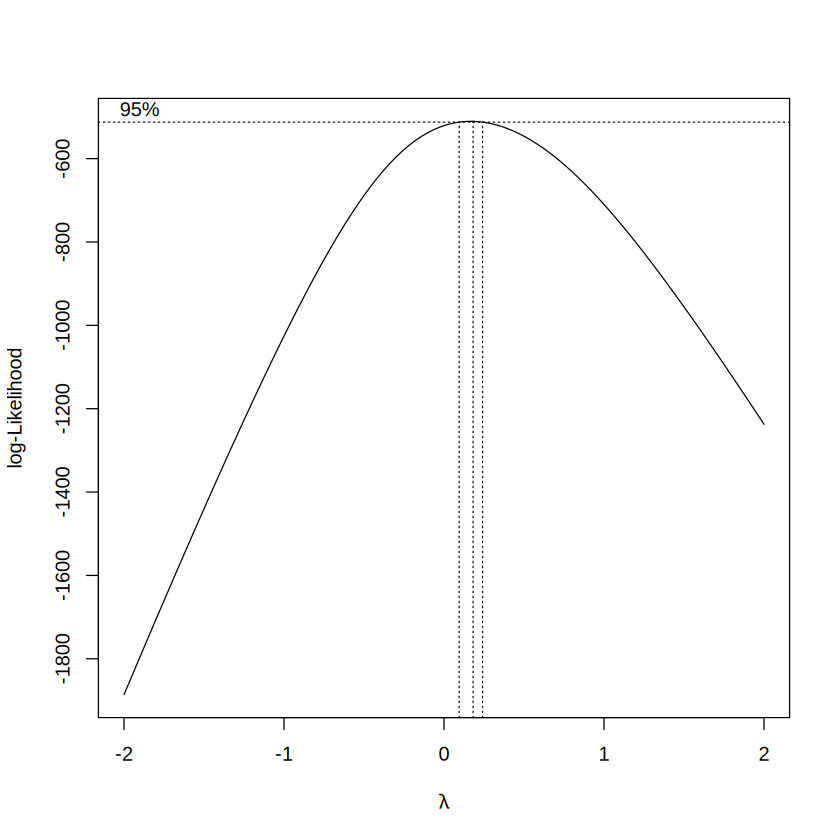

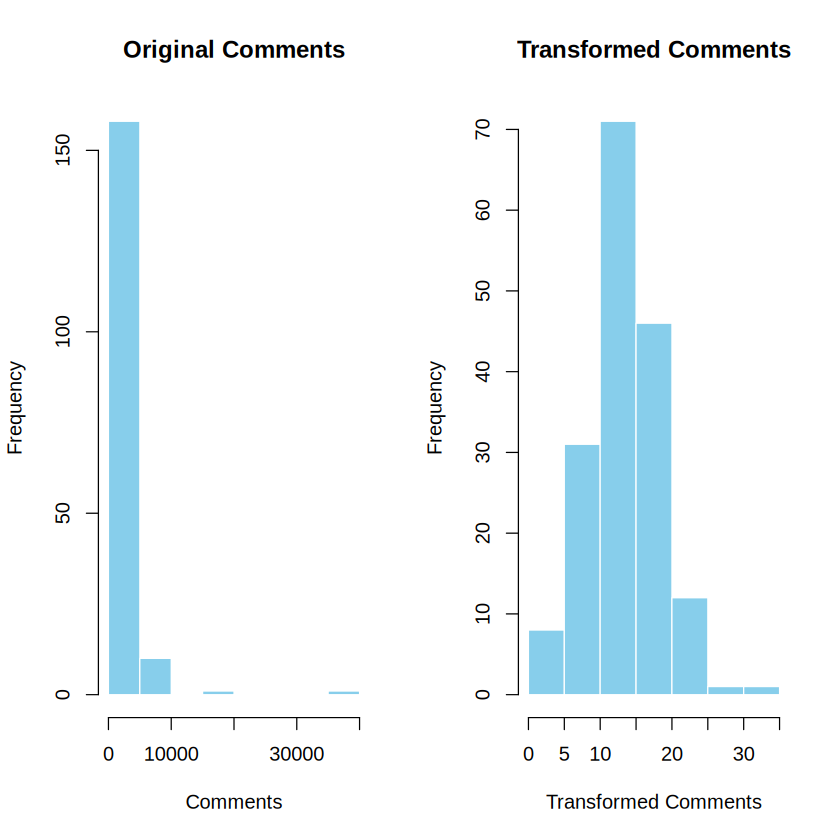

In [58]:
response_variable <- cleaned_df$Comments[cleaned_df$Comments != 0]
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original Comments", xlab = "Comments", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed Comments", xlab = "Transformed Comments", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `Comments` đã tương đối chuẩn hơn.

In [59]:
cleaned_df$Comments <- (cleaned_df$Comments^optimal_lambda - 1) / optimal_lambda

### Phân tích biến `AggregateFollowers`

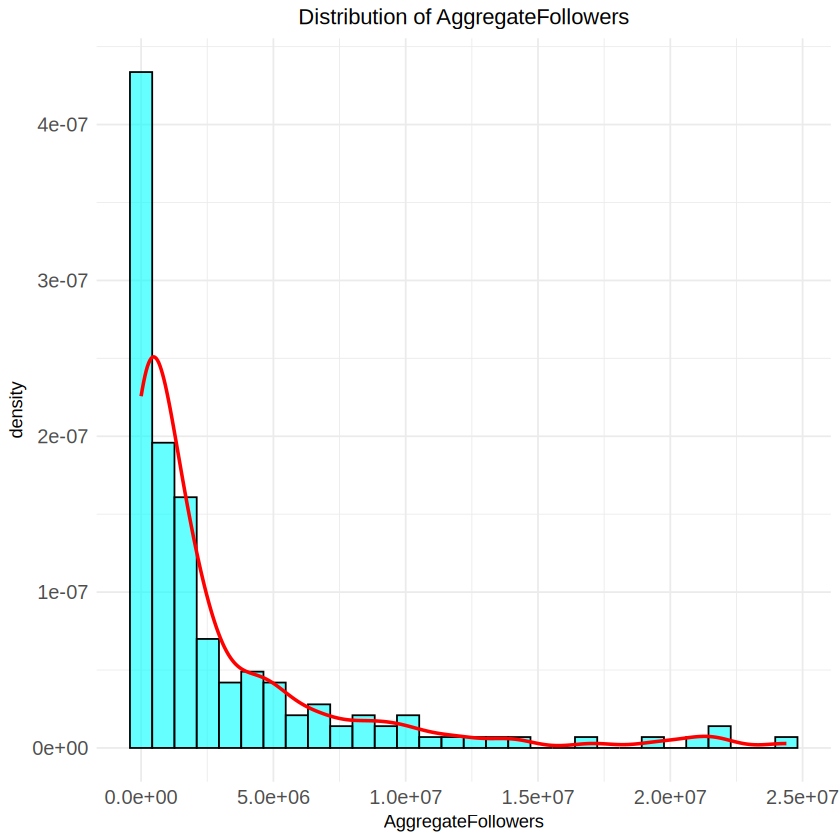

In [60]:
# tidy_empirical(train$AggregateFollowers) |> tidy_autoplot()
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

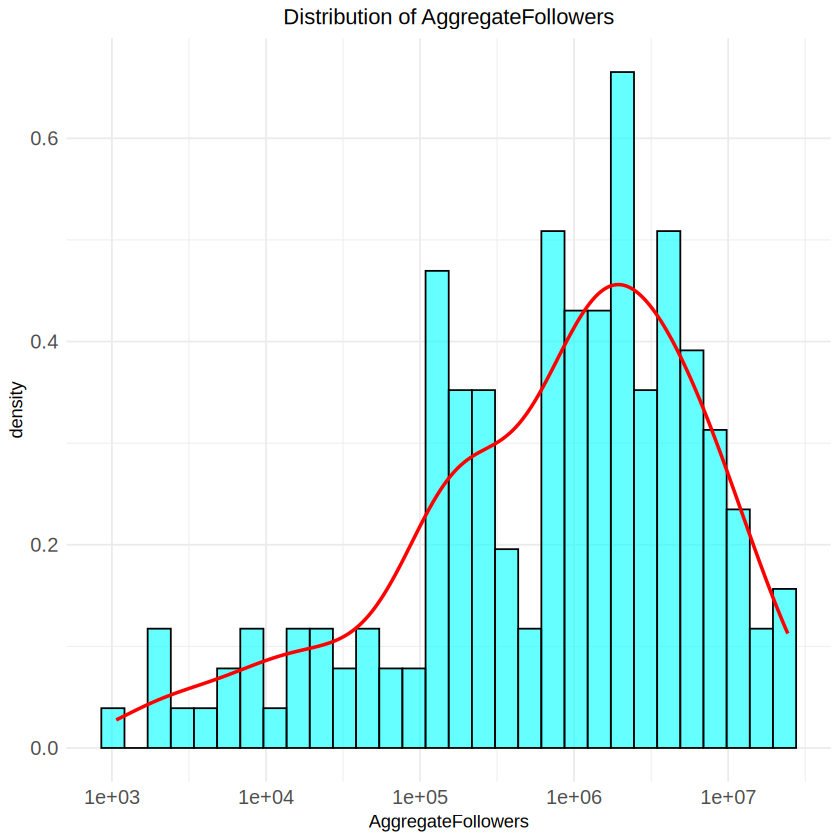

In [61]:
ggplot(cleaned_df, aes(x = AggregateFollowers)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "cyan", color = "black", alpha = 0.6) +
  geom_density(color = "red", size = 1) +
  theme_minimal() +
  scale_x_log10(oob = scales::squish_infinite) +  # Apply log scale to the x-axis
  ggtitle("Distribution of AggregateFollowers") +
  theme(
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(size = 12),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 12)   # Increase font size for y-axis labels
  )

[1] "Optimal lambda:  0.141414141414141"


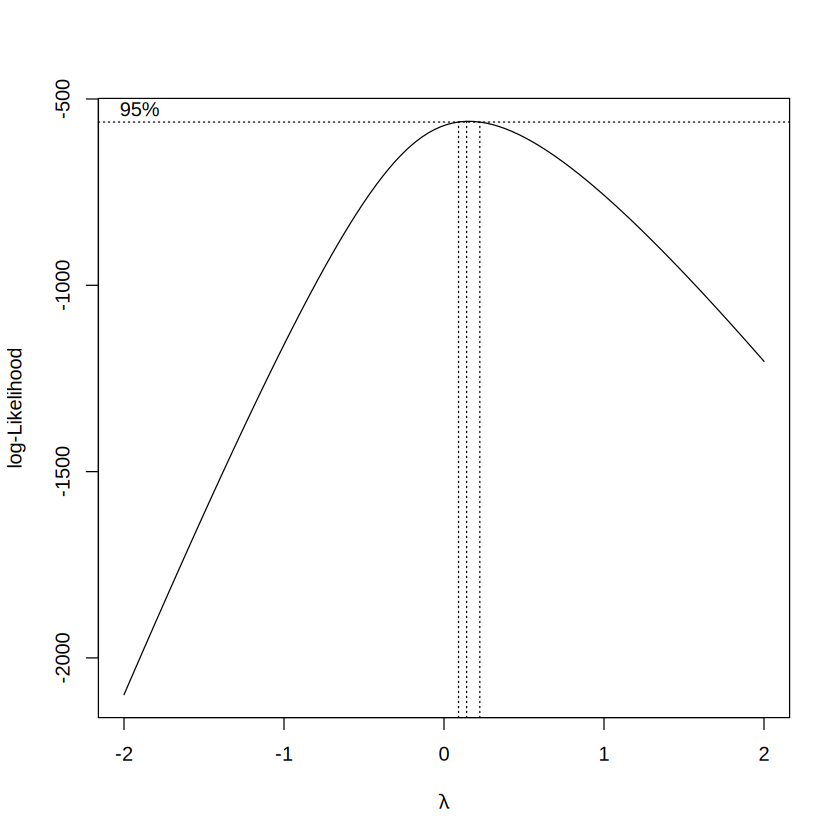

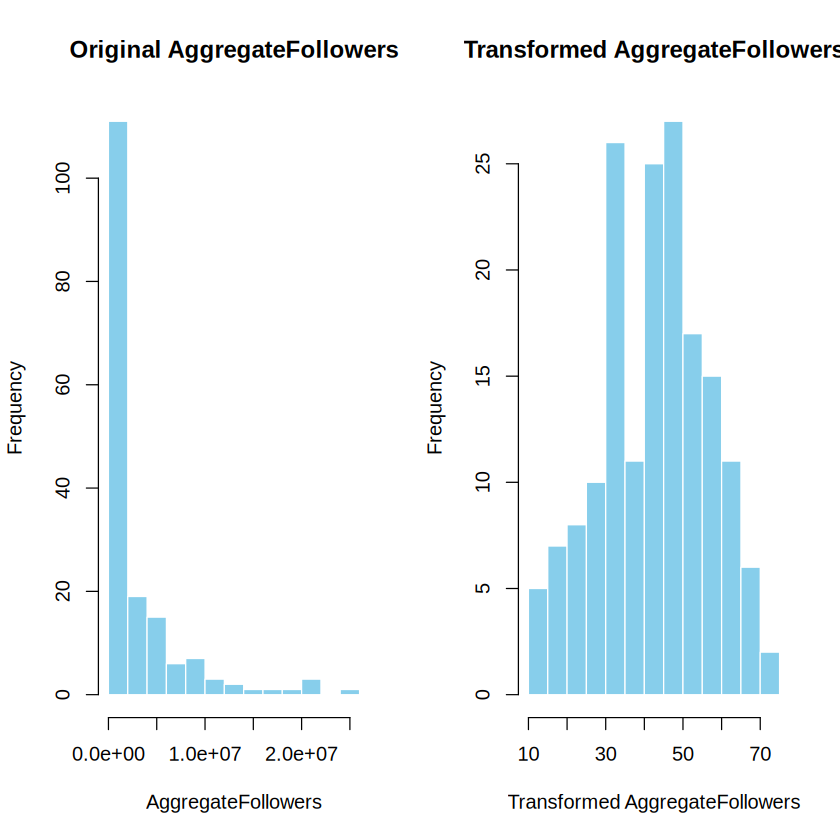

In [62]:
response_variable <- cleaned_df$AggregateFollowers
transformed_response <- log(response_variable)

boxcox_result <- boxcox(response_variable ~ 1, plotit = TRUE)

optimal_lambda <- boxcox_result$x[which.max(boxcox_result$y)]
print(paste("Optimal lambda: ", optimal_lambda))
if (optimal_lambda == 0) {
  transformed_response <- log(response_variable)
} else {
  transformed_response <- (response_variable^optimal_lambda - 1) / optimal_lambda
}

par(mfrow = c(1, 2)) # Split the plotting window into 1 row and 2 columns
hist(response_variable, main = "Original AggregateFollowers", xlab = "AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
hist(transformed_response, main = "Transformed AggregateFollowers", xlab = "Transformed AggregateFollowers", ylab = "Frequency", col = "skyblue", border = "white")
par(mfrow = c(1, 1))

**Nhận xét**:
- Dựa vào biểu đồ, ta thấy sau khi sử dụng log-transform, biến `AggregateFollowers` đã tương đối chuẩn hơn.

In [63]:
cleaned_df$AggregateFollowers <- (cleaned_df$AggregateFollowers^optimal_lambda - 1) / optimal_lambda

## Phân chia tập dữ liệu

In [64]:
split_ratio <- 0.8
split_index <- floor(nrow(cleaned_df) * split_ratio)

train = cleaned_df[1:split_index,]
test = cleaned_df[(split_index + 1):nrow(cleaned_df),]

In [65]:
# số chiều tập train
dim(train)
rownames(train) <- 1:nrow(train)

[1] 136   4

In [66]:
# số chiều tập test
dim(test)
rownames(test) <- 1:nrow(test)

[1] 34  4

In [67]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	136 obs. of  4 variables:
 $ Gross             : num  63.8 2033.8 1082.3 1657.9 888.2 ...
 $ Dislikes          : num  11.03 6.11 4.94 7.86 12.15 ...
 $ Comments          : num  12.29 8.72 5.58 12.05 14.09 ...
 $ AggregateFollowers: num  43.6 64.1 37.9 39 47.7 ...


## Mô hình hóa

### Khảo sát sự tương quan giữa các biến

In [68]:
# round(cor(train[, c(1:13)]), 2)
round(cor(train), 2)

,Gross,Dislikes,Comments,AggregateFollowers
Gross,1.00,0.37,0.40,0.29
Dislikes,0.37,1.00,0.85,0.30
Comments,0.40,0.85,1.00,0.24
AggregateFollowers,0.29,0.30,0.24,1.00


Một số nhận xét:
- Biến `Ratings` và biến `AggregateFollowers` có tương quan với biến `Gross` cao, lần lượt 0.38 và 0.26
- Các biến `Dislikes` và `Comments` có tương quan với biến `Gross` thấp hơn hai biến còn lại, 0.20
- Biến `Comments` có tương quan cao với biến `Dislikes`, 0.89
- Biến `Comments` có tương quan nghịch với biến `Ratings`, -0.12

### Xây dựng mô hình đầy đủ

In [69]:
str(train)

'data.frame':	136 obs. of  4 variables:
 $ Gross             : num  63.8 2033.8 1082.3 1657.9 888.2 ...
 $ Dislikes          : num  11.03 6.11 4.94 7.86 12.15 ...
 $ Comments          : num  12.29 8.72 5.58 12.05 14.09 ...
 $ AggregateFollowers: num  43.6 64.1 37.9 39 47.7 ...


In [70]:
full.lm <- lm(Gross ~ ., data = train)
print(summary(full.lm))


Call:
lm(formula = Gross ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1121.78  -251.73    43.18   335.70   999.91 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)  
(Intercept)         369.998    159.862   2.314   0.0222 *
Dislikes              6.643     19.501   0.341   0.7339  
Comments             32.006     15.531   2.061   0.0413 *
AggregateFollowers    8.003      3.210   2.493   0.0139 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 490.2 on 132 degrees of freedom
Multiple R-squared:  0.199,	Adjusted R-squared:  0.1808 
F-statistic: 10.93 on 3 and 132 DF,  p-value: 1.848e-06



### Lựa chọn model tốt nhất

Với số lượng lớn các yếu tố dự đoán, điều quan trọng là phải giảm thiểu mô hình bằng cách chỉ bao gồm các yếu tố dự đoán hữu ích. Có tất cả 6 yếu tố dự đoán trong tập dữ liệu, nghĩ là có thể có $2^{12}$ mô hình hồi quy. Để chọn mô hình một cách hiệu quả, việc lựa chọn lùi được thực hiện bằng sử dụng step function. Phương pháp này lặp lại các quy trình để giảm thiểu Akaike’s Information Criteria (AIC) và Bayesian Information Criteria (BIC). Lựa chọn mô hình ngược so với lựa chọn tiến vì nó loại bỏ khả năng một yếu tố dự đoán mới được chọn có khả năng tương tự hoặc nhiều hơn để giải thích các phần của phản hồi đã được giải thích bởi một yếu tố dự đoán khác có trong mô hình.

In [71]:
# Model lower bound
model.lb <- lm(Gross ~ 1, data = train) 

In [72]:
# Model upper bound
model.up <- full.lm

In [73]:
step(full.lm, scope = list(lower = model.lb, upper = model.up), direction = "both", trace = FALSE)


Call:
lm(formula = Gross ~ Comments + AggregateFollowers, data = train)

Coefficients:
       (Intercept)            Comments  AggregateFollowers  
           372.384              36.441               8.196  


In [74]:
csm_models<- regsubsets(Gross ~  Comments + AggregateFollowers, data = train)
summary.csm<-summary(csm_models)

In [75]:
#picking the best regression model using reg subsets 
summary.csm$which

,(Intercept),Comments,AggregateFollowers
1,TRUE,TRUE,FALSE
2,TRUE,TRUE,TRUE


In [76]:
#Criteria
# model with largest increase in R^2 (equivalent to smallest MSE)
summary.csm$rsq

[1] 0.1574349 0.1982847

In [77]:
# model with largest adjusted R^2 
summary.csm$adjr2

[1] 0.1511471 0.1862288

In [78]:
# model with smallest Mallow's Cp
summary.csm$cp

[1] 7.776736 3.000000

#### Chọn mô hình tốt nhất dựa trên BIC

In [79]:
# model with lowest bic
summary.csm$bic

[1] -13.47209 -15.31826

In [80]:
best_model_index <- which.min(summary.csm$bic)
best_model <- summary.csm$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

       (Intercept)           Comments AggregateFollowers 
              TRUE               TRUE               TRUE 
[1] "Comments"           "AggregateFollowers"


In [81]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("Gross ~", paste(best_vars, collapse = " + "))
best_model_csm <- lm(as.formula(formula_str), data=train)

In [82]:
# Tóm tắt mô hình
summary(best_model_csm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1116.43  -242.33    38.26   363.37   990.38 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         372.384    159.177   2.339   0.0208 *  
Comments             36.441      8.437   4.319 3.04e-05 ***
AggregateFollowers    8.196      3.149   2.603   0.0103 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 488.6 on 133 degrees of freedom
Multiple R-squared:  0.1983,	Adjusted R-squared:  0.1862 
F-statistic: 16.45 on 2 and 133 DF,  p-value: 4.143e-07


Như vậy, ta thu được mô hình

```
Gross ~ -122.1864 (Intercept) + 10.4108 * Ratings + 0.8301 * Budget + 1.0321 * Screens -0.6779 * Views + 12.8582 * Dislikes
```

Điều này có ý nghĩa là, biến `Gross` sẽ được giải thích thông qua hai biến `Ratings` và `Dislikes` 
- Điểm xếp hạng càng cao thì doanh thu của một bộ phim cũng cao (hợp lý theo logic thông thường).
- Số lượt chê càng cao thì doanh thu của một bộ phim cũng cao. Điều này có thể lý giải, khi một bộ phim có nhiều bình luận tiêu cực, người ta sẽ có hứng thú đi xem nó để biết tại sao nó bị chê (yếu tố tò mò).

Bây giờ, ta sẽ đi phân tích xem mô hình này có thỏa những giả định của mô hình hồi quy bội hay không?

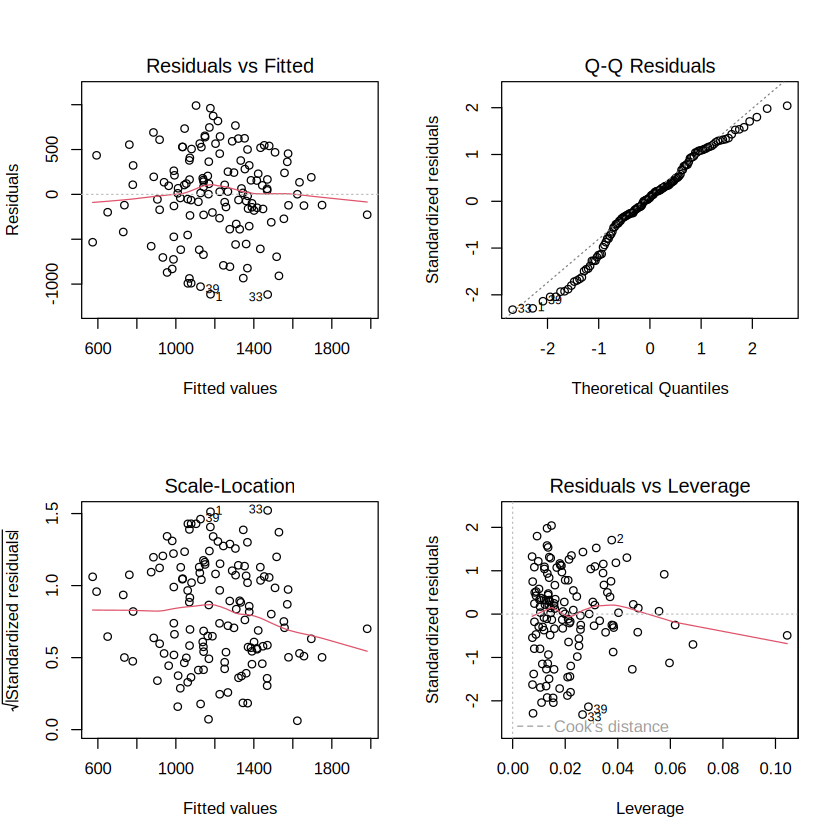

In [83]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_csm)

#### Phân tích Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

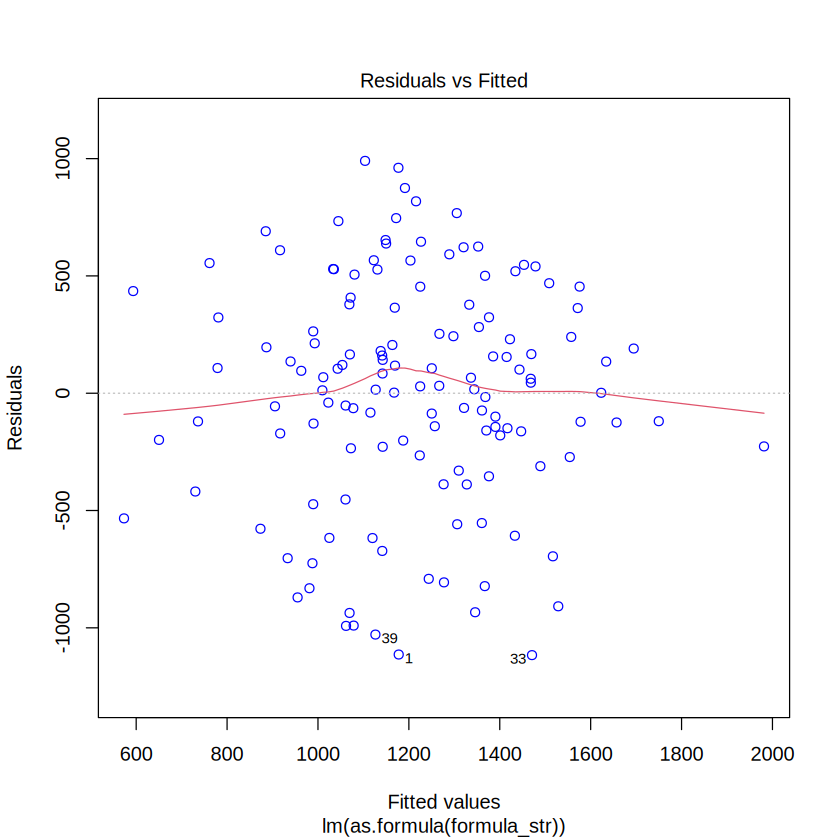

In [84]:
plot(best_model_csm, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng chưa gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương chưa đồng đều. Điều này chứng tỏ có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Phân tích Normal Q–Q (quantile-quantile) Plot

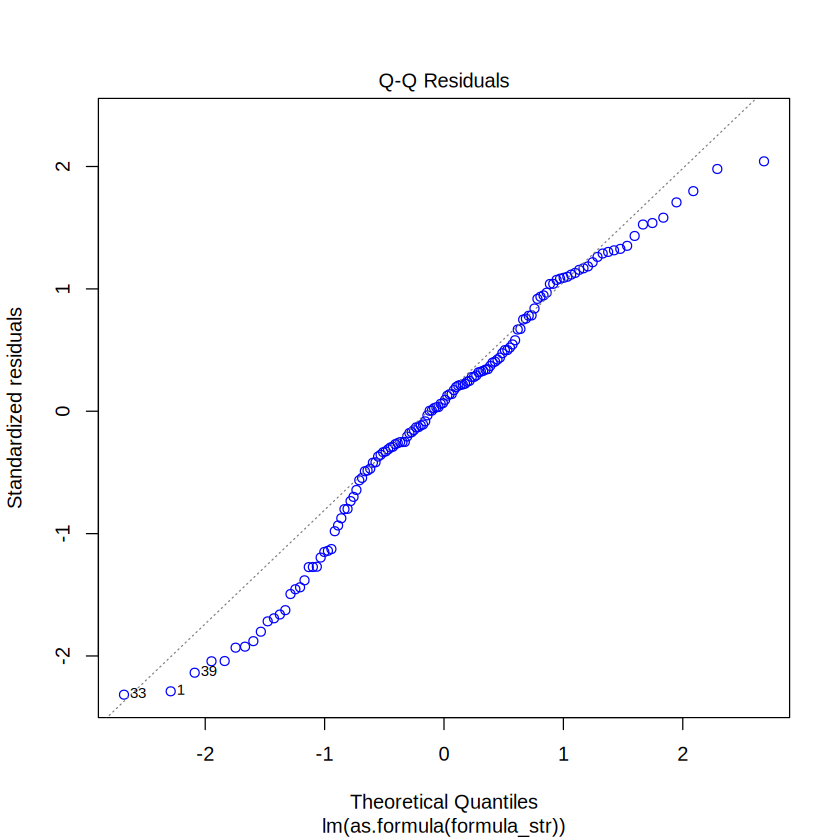

In [85]:
plot(best_model_csm, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [86]:
# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm))


	Shapiro-Wilk normality test

data:  residuals(best_model_csm)
W = 0.97631, p-value = 0.01797


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Phân tích Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

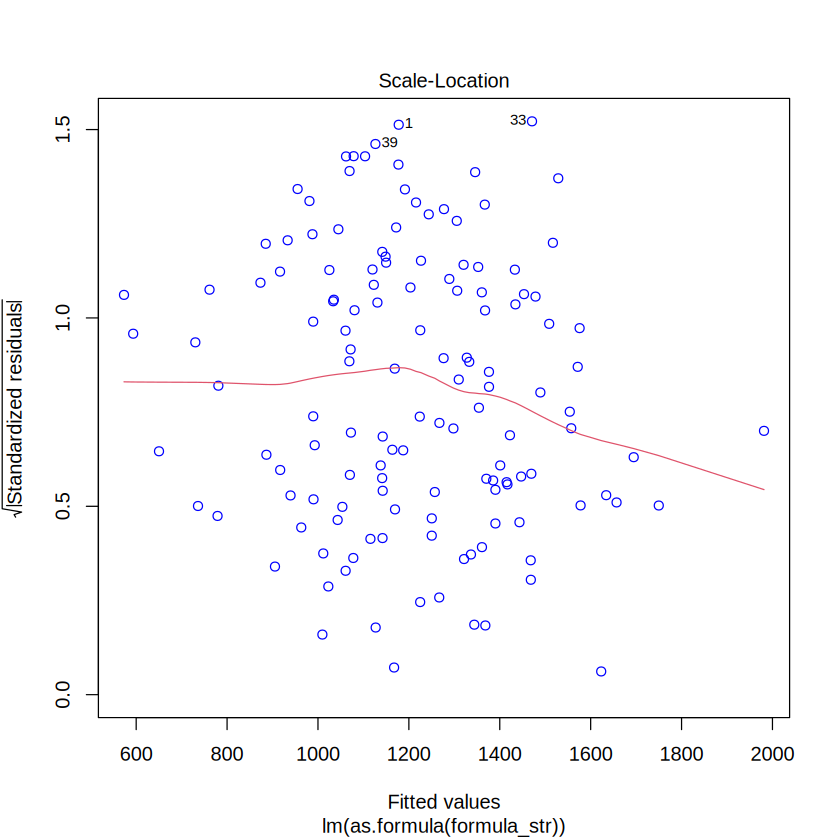

In [87]:
plot(best_model_csm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [88]:
# Breusch-Pagan Test
bptest(best_model_csm)


	studentized Breusch-Pagan test

data:  best_model_csm
BP = 3.5471, df = 2, p-value = 0.1697


Như vậy, ta thấy p-value lớn hơn múc ý nghĩa 0.05 rất nhiều, ta đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là heteroscedastic

#### Phân tích Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

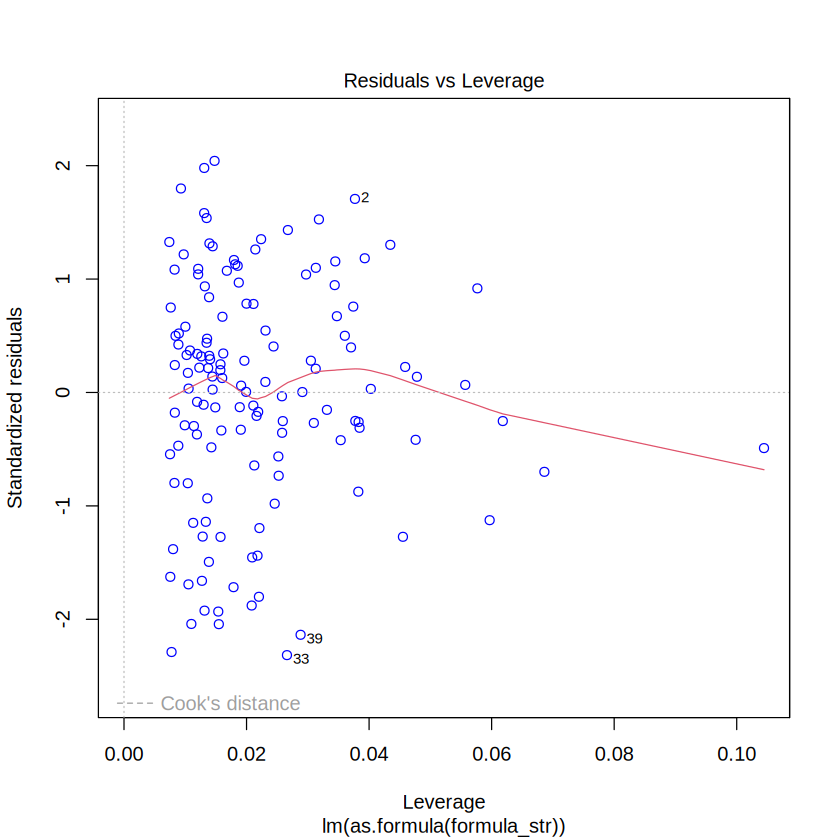

In [89]:
plot(best_model_csm, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

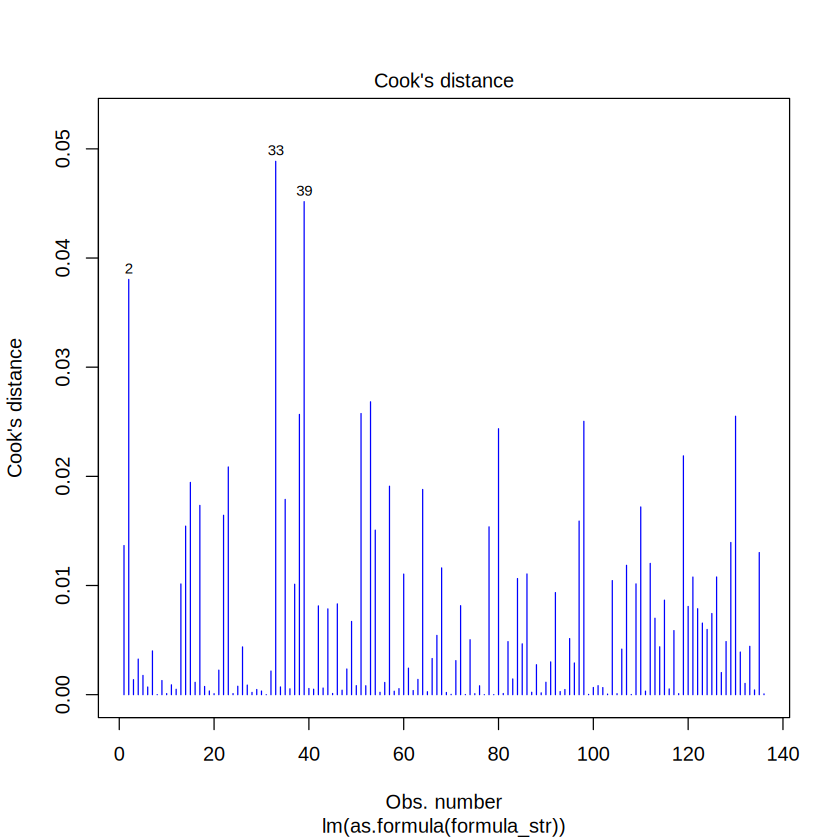

In [90]:
plot(best_model_csm, which=4, col=c("blue"))

Kết luận:
- Mô hình thu được có thể được sử dụng để đem đi dự đoán.

### Loại bỏ ngoại lai dựa trên Cook'Distance

In [91]:
# Xây dựng ngưỡng cho Cook Distance
threshold <- 4 / nrow(train)
threshold

[1] 0.02941176

In [92]:
# Tính toán Cook Distance
cooks_d <- cooks.distance(best_model_csm)

# Xác định các influential point dựa trên ngưỡng
influential_points <- which(cooks_d > threshold)

# Xây dựng model
best_model_csm.2 <- lm(as.formula(formula_str), data=train[-c(influential_points), ])
summary(best_model_csm.2)

# Shapiro-Wilk normality test
shapiro.test(residuals(best_model_csm.2))

# Breusch-Pagan Test
bptest(best_model_csm.2)



Call:
lm(formula = as.formula(formula_str), data = train[-c(influential_points), 
    ])

Residuals:
     Min       1Q   Median       3Q      Max 
-1125.52  -237.46    30.86   356.05   993.04 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         348.376    153.938   2.263  0.02529 *  
Comments             35.870      8.234   4.356 2.66e-05 ***
AggregateFollowers    9.175      3.120   2.941  0.00387 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 470.2 on 130 degrees of freedom
Multiple R-squared:  0.222,	Adjusted R-squared:   0.21 
F-statistic: 18.54 on 2 and 130 DF,  p-value: 8.226e-08



	Shapiro-Wilk normality test

data:  residuals(best_model_csm.2)
W = 0.97941, p-value = 0.04125



	studentized Breusch-Pagan test

data:  best_model_csm.2
BP = 2.1782, df = 2, p-value = 0.3365


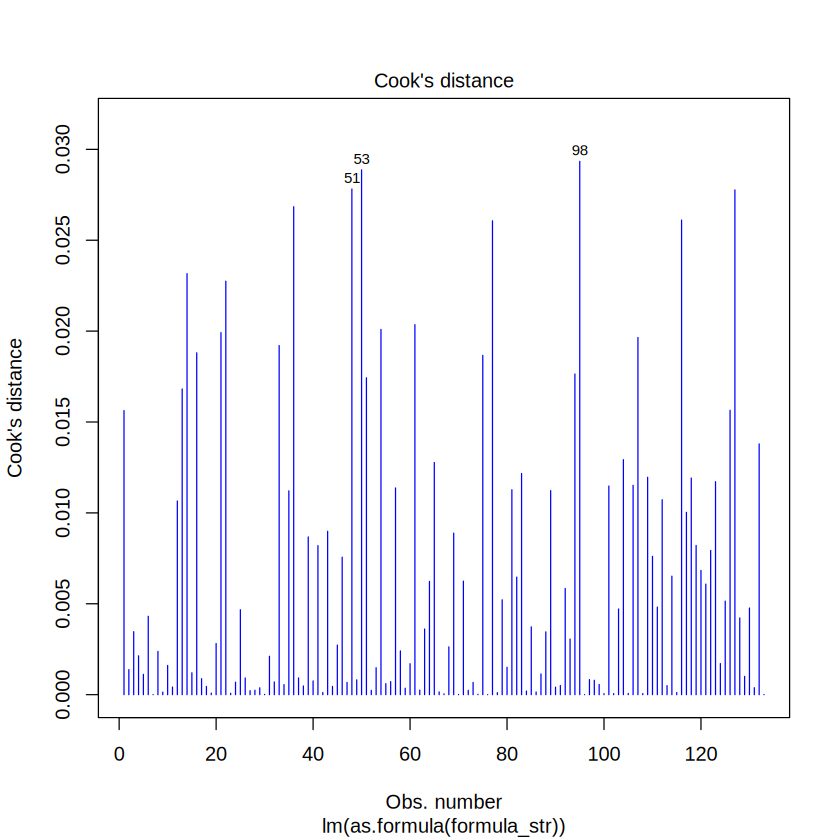

In [93]:
plot(best_model_csm.2, which=4, col=c("blue"))

### Dự đoán và đánh giá kết quả

[1] 402.7323

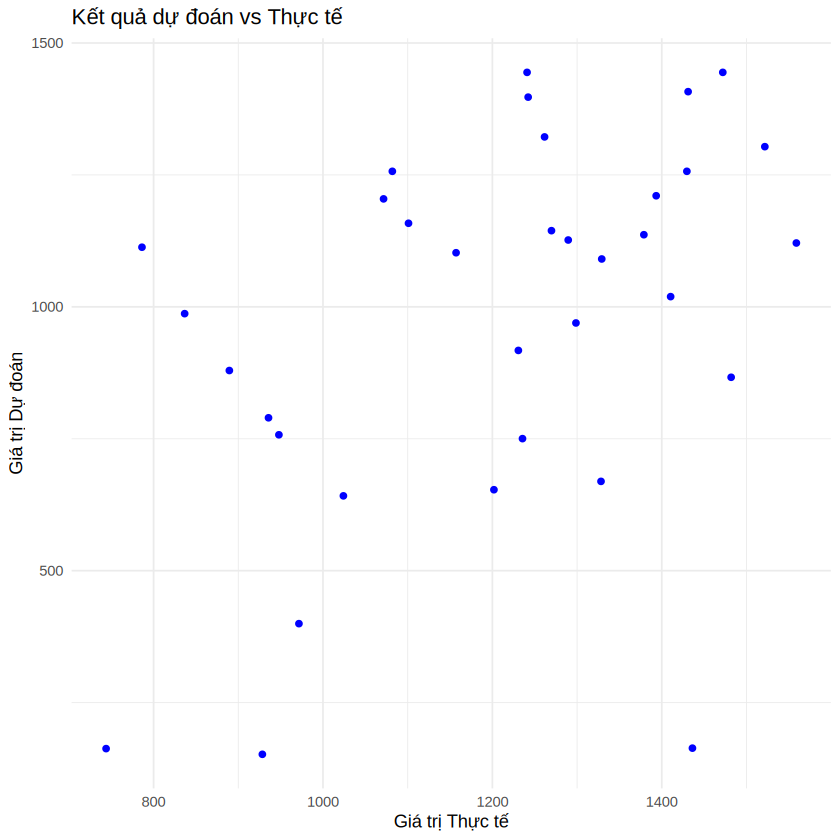

In [96]:
# predict
results <- predict(best_model_csm, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)

[1] 408.45

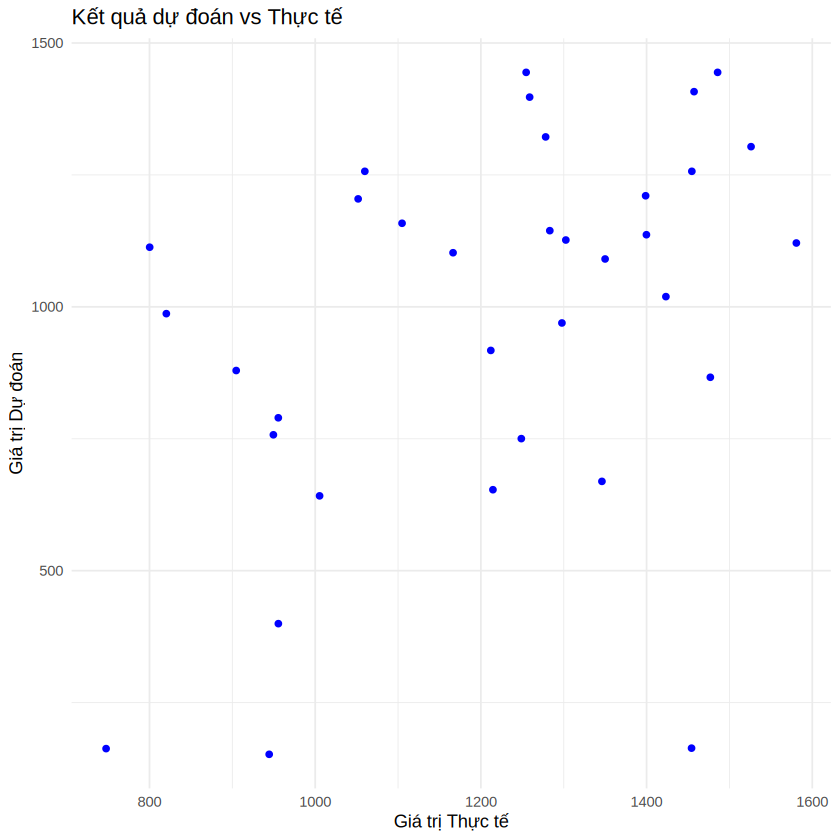

In [97]:
# predict
results <- predict(best_model_csm.2, test)
df <- data.frame(
    du_doan <- results,
    label <- test$Gross
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

rmse(results, test$Gross)